In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import glob
import gc
import string
from unicodedata import normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping

import nltk
from nltk.tokenize import RegexpTokenizer
import spacy


# Carregar Dados

In [103]:
files=glob.glob('../archive/*.csv')
files

['../archive/parque_chapada_dos_veadeiros.csv',
 '../archive/mercado-ver-o-peso-pa.csv',
 '../archive/beto-carreiro-sc.csv',
 '../archive/pelourinho_ba.csv',
 '../archive/praia-copacabana-rj.csv',
 '../archive/museu_imperial.csv',
 '../archive/praca-3-poderes-br.csv',
 '../archive/museu_arte_sp.csv',
 '../archive/jardim_botanico.csv',
 '../archive/elevador_lacerda.csv',
 '../archive/aqua-rio-rj.csv',
 '../archive/parque_jalapao.csv',
 '../archive/parque_nacional_iguacu.csv',
 '../archive/mercado-central-fortaleza-ce.csv',
 '../archive/hopi_hari.csv']

In [104]:
#dados será um dicionário com os comentários e as notas de cada usuário
# as chaves do dicionário serão os nomes dos destinos turísticos

dados={}

for file in files:
    dados[file.split('/')[-1].split('.')[0]]=pd.read_csv(file, delimiter=';')



In [105]:
dados.keys()
nomes_destinos=list(dados.keys())

In [106]:
print('Destinos turísticos avaliados:')
print('')
for nome_destino in nomes_destinos:
    print(nome_destino)

Destinos turísticos avaliados:

parque_chapada_dos_veadeiros
mercado-ver-o-peso-pa
beto-carreiro-sc
pelourinho_ba
praia-copacabana-rj
museu_imperial
praca-3-poderes-br
museu_arte_sp
jardim_botanico
elevador_lacerda
aqua-rio-rj
parque_jalapao
parque_nacional_iguacu
mercado-central-fortaleza-ce
hopi_hari


# Análise Exploratória - Notas

## Comparativo entre as notas dos destinos turísticos

'''
Nessa seção será feito um comparativo entre as avaliações (somente das notas) recebidas por cada uma das atrações.
As atrações foram avaliadas com notas variando entre 1 e 5, sendo 5 a melhor nota.
'''

In [107]:
#Verificando a existência de entradas nulas
print('Número de entradas nulas para as notas das atrações:')
print('')
for nome in nomes_destinos:
    print(nome+ ' : {}'.format(dados[nome]['nota'].isnull().sum()))

Número de entradas nulas para as notas das atrações:

parque_chapada_dos_veadeiros : 0
mercado-ver-o-peso-pa : 0
beto-carreiro-sc : 0
pelourinho_ba : 0
praia-copacabana-rj : 0
museu_imperial : 0
praca-3-poderes-br : 0
museu_arte_sp : 0
jardim_botanico : 0
elevador_lacerda : 0
aqua-rio-rj : 0
parque_jalapao : 0
parque_nacional_iguacu : 0
mercado-central-fortaleza-ce : 0
hopi_hari : 0


### Nota média de cada destino turistico

In [108]:
dados_nota_media={}
for destino in nomes_destinos:
    dados_nota_media[destino]=dados[destino]['nota'].mean()
dados_nota_media=pd.DataFrame.from_dict(dados_nota_media,orient='index').rename(columns={0:'Nota_Média'}).sort_values(by='Nota_Média',ascending=False)
dados_nota_media.index.rename('Destino',inplace=True)
dados_nota_media

,Nota_Média
Destino,
parque_nacional_iguacu,4.837884
parque_chapada_dos_veadeiros,4.788469
parque_jalapao,4.781955
museu_imperial,4.655708
jardim_botanico,4.628761
museu_arte_sp,4.554544
praia-copacabana-rj,4.371347
praca-3-poderes-br,4.250324
aqua-rio-rj,4.127649


<Axes: title={'center': 'Nota média de cada destino'}, xlabel='Destino', ylabel='Nota_Média'>

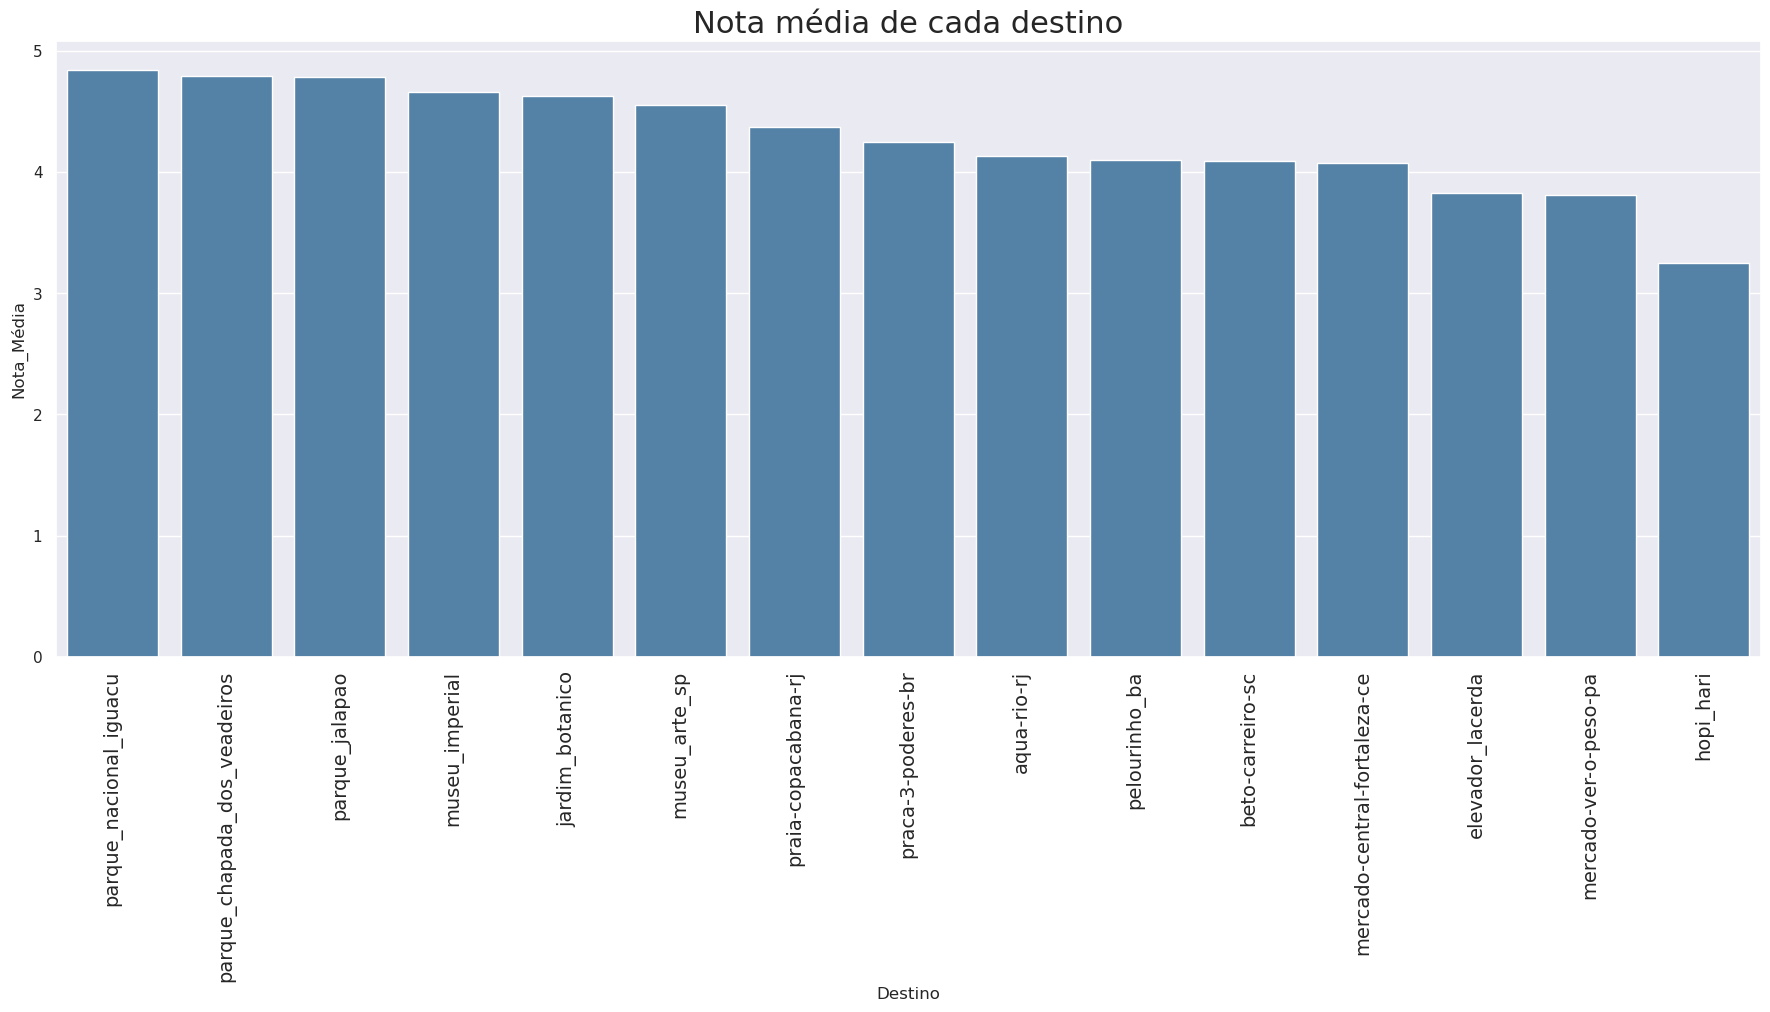

In [109]:
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.title('Nota média de cada destino',fontsize = 22)
plt.xticks(rotation=90,fontsize=14)
sns.barplot(dados_nota_media,x=dados_nota_media.index,y='Nota_Média',color='steelblue')



### Proporção de avaliações com cada nota para cada destino turístico

In [110]:
#Calcular a proporção das notas em relação ao número de avaliações
proporcao_notas=[]
for destino in nomes_destinos:
    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))
    proporcao_notas+=[[(dados[destino]['nota']==nota).sum() for nota in [1,2,3,4,5]]]
proporcao_notas=pd.DataFrame(proporcao_notas,index=nomes_destinos)
proporcao_notas["Total Avaliações"]=proporcao_notas.sum(axis=1)
proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
proporcao_notas.columns=   ['nota 1(%)',
                            'nota 2(%)',
                            'nota 3(%)',
                            'nota 4(%)',
                            'nota 5(%)',
                             "Total Avaliações"]

/tmp/ipykernel_593851/3708725821.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'parque_chapada_dos_veadeiros    0.002203
mercado-ver-o-peso-pa           0.046576
beto-carreiro-sc                0.093956
pelourinho_ba                   0.024637
praia-copacabana-rj             0.011091
museu_imperial                  0.002822
praca-3-poderes-br              0.006485
museu_arte_sp                   0.004138
jardim_botanico                 0.001403
elevador_lacerda                0.026991
aqua-rio-rj                     0.025720
parque_jalapao                  0.000000
parque_nacional_iguacu          0.001532
mercado-central-fortaleza-ce    0.012190
hopi_hari                       0.164688
Name: 0, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
/tmp/ipykern

In [111]:
#O dataframe proporcao_notas exibe o total de avaliações de cada destino turístico e a proporção desse total correspondentes as 
#notas 1,2,3,4 e 5
proporcao_notas

,nota 1(%),nota 2(%),nota 3(%),nota 4(%),nota 5(%),Total Avaliações
parque_chapada_dos_veadeiros,0.002203,0.003672,0.021667,0.148366,0.824091,2723
mercado-ver-o-peso-pa,0.046576,0.079845,0.222345,0.319379,0.331855,3607
beto-carreiro-sc,0.093956,0.056684,0.080756,0.203572,0.565032,7727
pelourinho_ba,0.024637,0.040003,0.165692,0.352347,0.417321,11974
praia-copacabana-rj,0.011091,0.023617,0.117563,0.278314,0.569415,7664
museu_imperial,0.002822,0.005080,0.034994,0.247778,0.709327,7087
praca-3-poderes-br,0.006485,0.016537,0.150778,0.372568,0.453632,3084
museu_arte_sp,0.004138,0.010760,0.060420,0.275782,0.648899,6041
jardim_botanico,0.001403,0.003724,0.050498,0.253458,0.690916,20674
elevador_lacerda,0.026991,0.064808,0.278066,0.317959,0.312176,6743


/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will

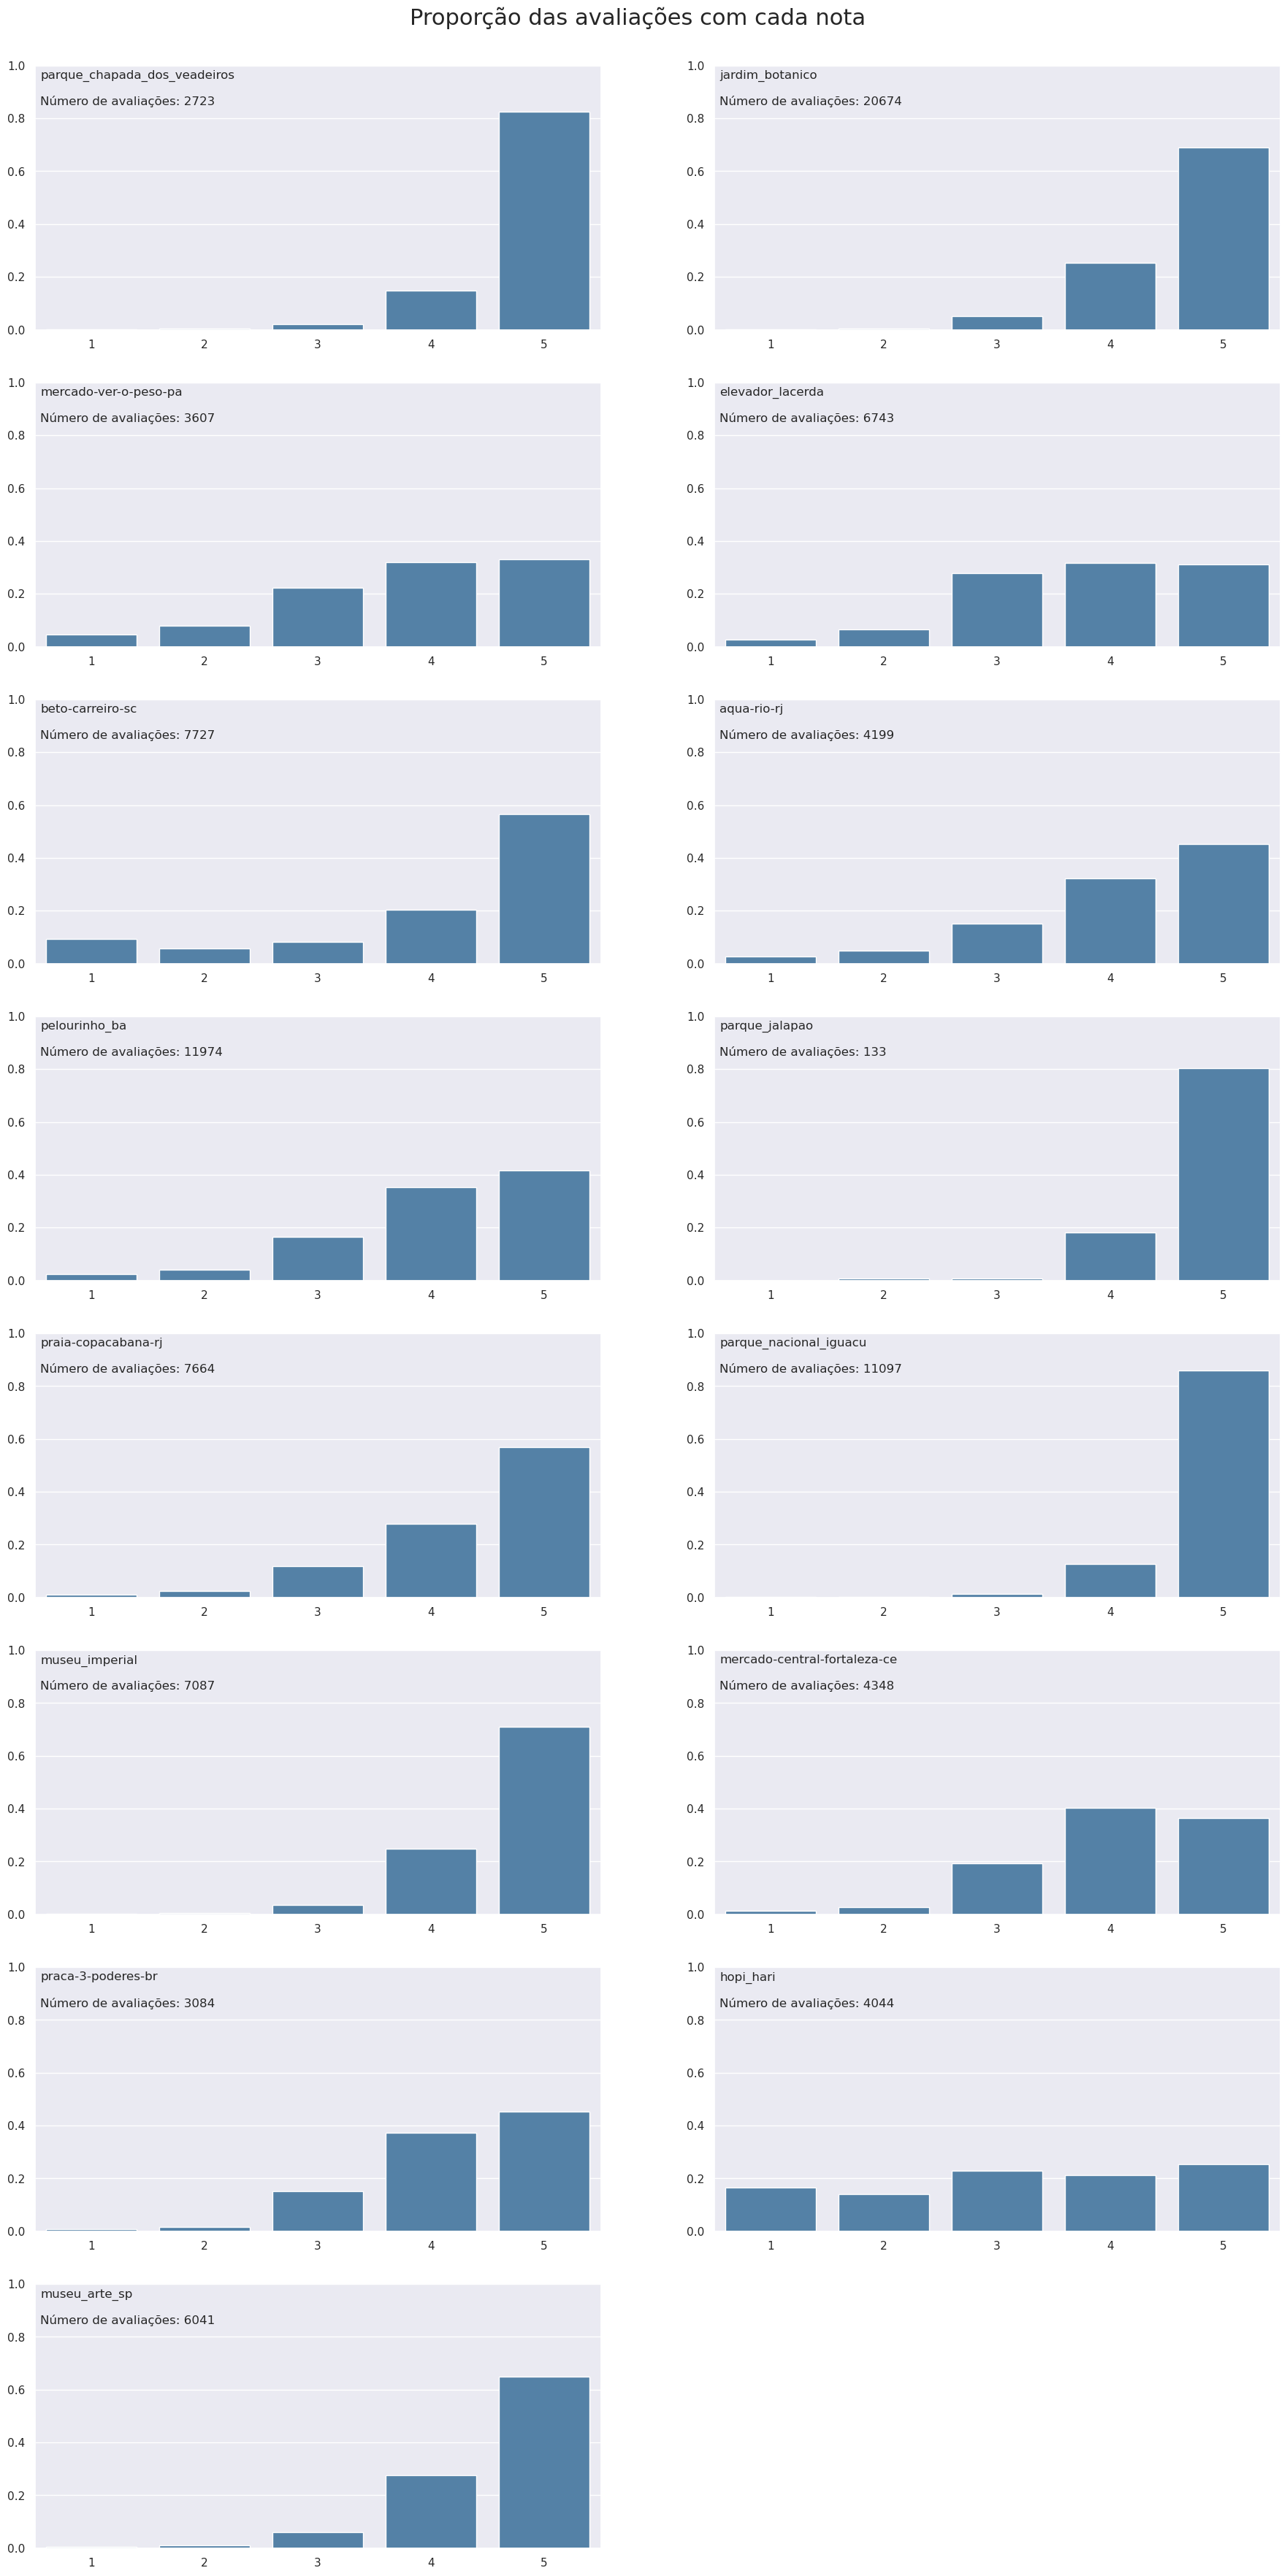

In [112]:
#Plotar graficos com as proporções das avaliações para cada destino
fig,axs=plt.subplots(8,2,figsize=(22,40))
plt.subplots_adjust(top=0.96) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Proporção das avaliações com cada nota', fontsize=22) #adiciona um título geral para os subplots
row_subplot=0
col_subplot=0
for num_destino in range(len(proporcao_notas)):
    destino=proporcao_notas.index[num_destino]
    sns.set_theme(style='darkgrid')
    ax=sns.barplot(x=[1,2,3,4,5],y=proporcao_notas.iloc[num_destino,:5],ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, destino)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(proporcao_notas.loc[destino,'Total Avaliações']))
    ax.set(ylabel=None)
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])


### Proporção de avaliações positivas, negativas e neutras

In [113]:
#Criação de dataframe com proporção de avaliações negativas, neutras e positivas

#Avaliação negativa - notas 1 e 2
#Avaliação neutra   - nota 3
#Avaliação positiva - notas 4 e 5


pos_neutra_neg=pd.concat((proporcao_notas.iloc[:,:2].sum(axis=1),
                          proporcao_notas.iloc[:,2],
                          proporcao_notas.iloc[:,3:5].sum(axis=1)),axis=1)
pos_neutra_neg.columns=['Negativas(%)',
                        'Neutras(%)',
                        'Positivas(%)']

pos_neutra_neg.sort_values(by=['Positivas(%)'],ascending=False,inplace=True)
pos_neutra_neg.index.rename('Destino',inplace=True)

[[<matplotlib.axis.YTick at 0x7efac48b1410>,

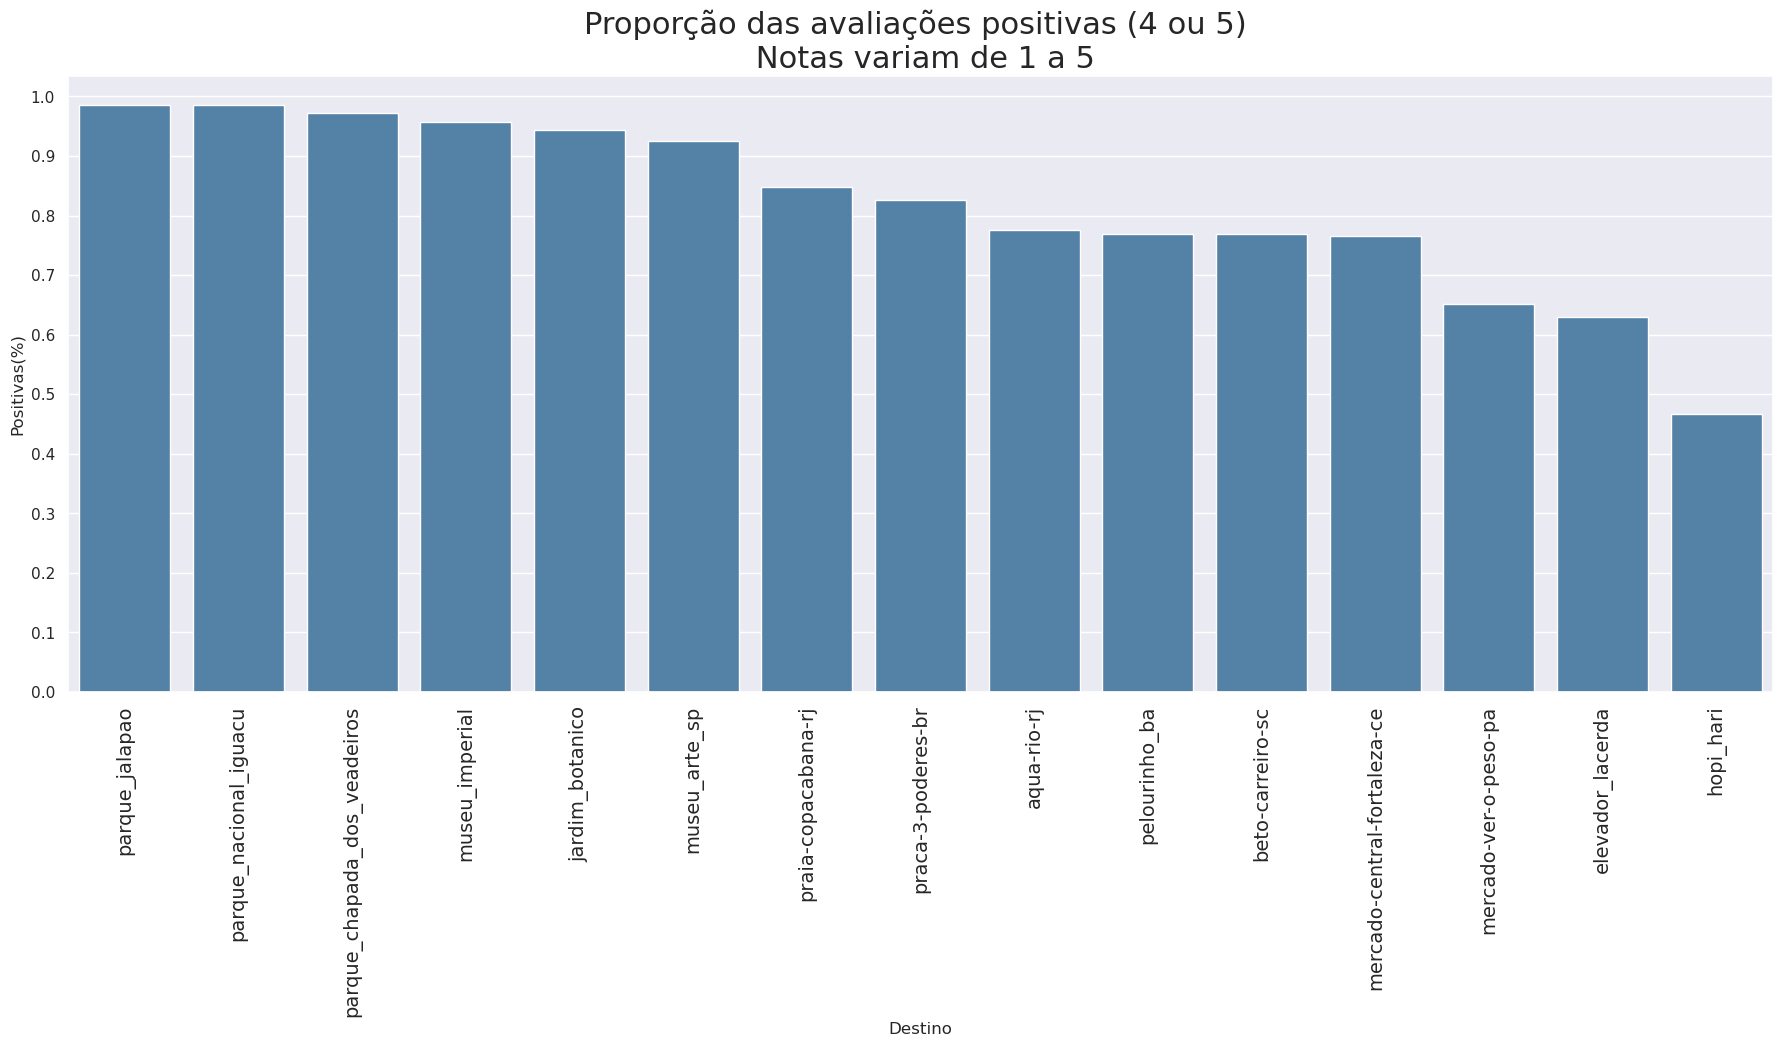

In [114]:
# Criação de gráfico para comparação entre a proporção das avaliações positivas
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações positivas (4 ou 5) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Positivas(%)'],ascending=False,inplace=True),x=pos_neutra_neg.index,y=pos_neutra_neg['Positivas(%)'],color='steelblue')
g.set(yticks=np.arange(0,1.1,0.1))


[[<matplotlib.axis.YTick at 0x7efac47031d0>,

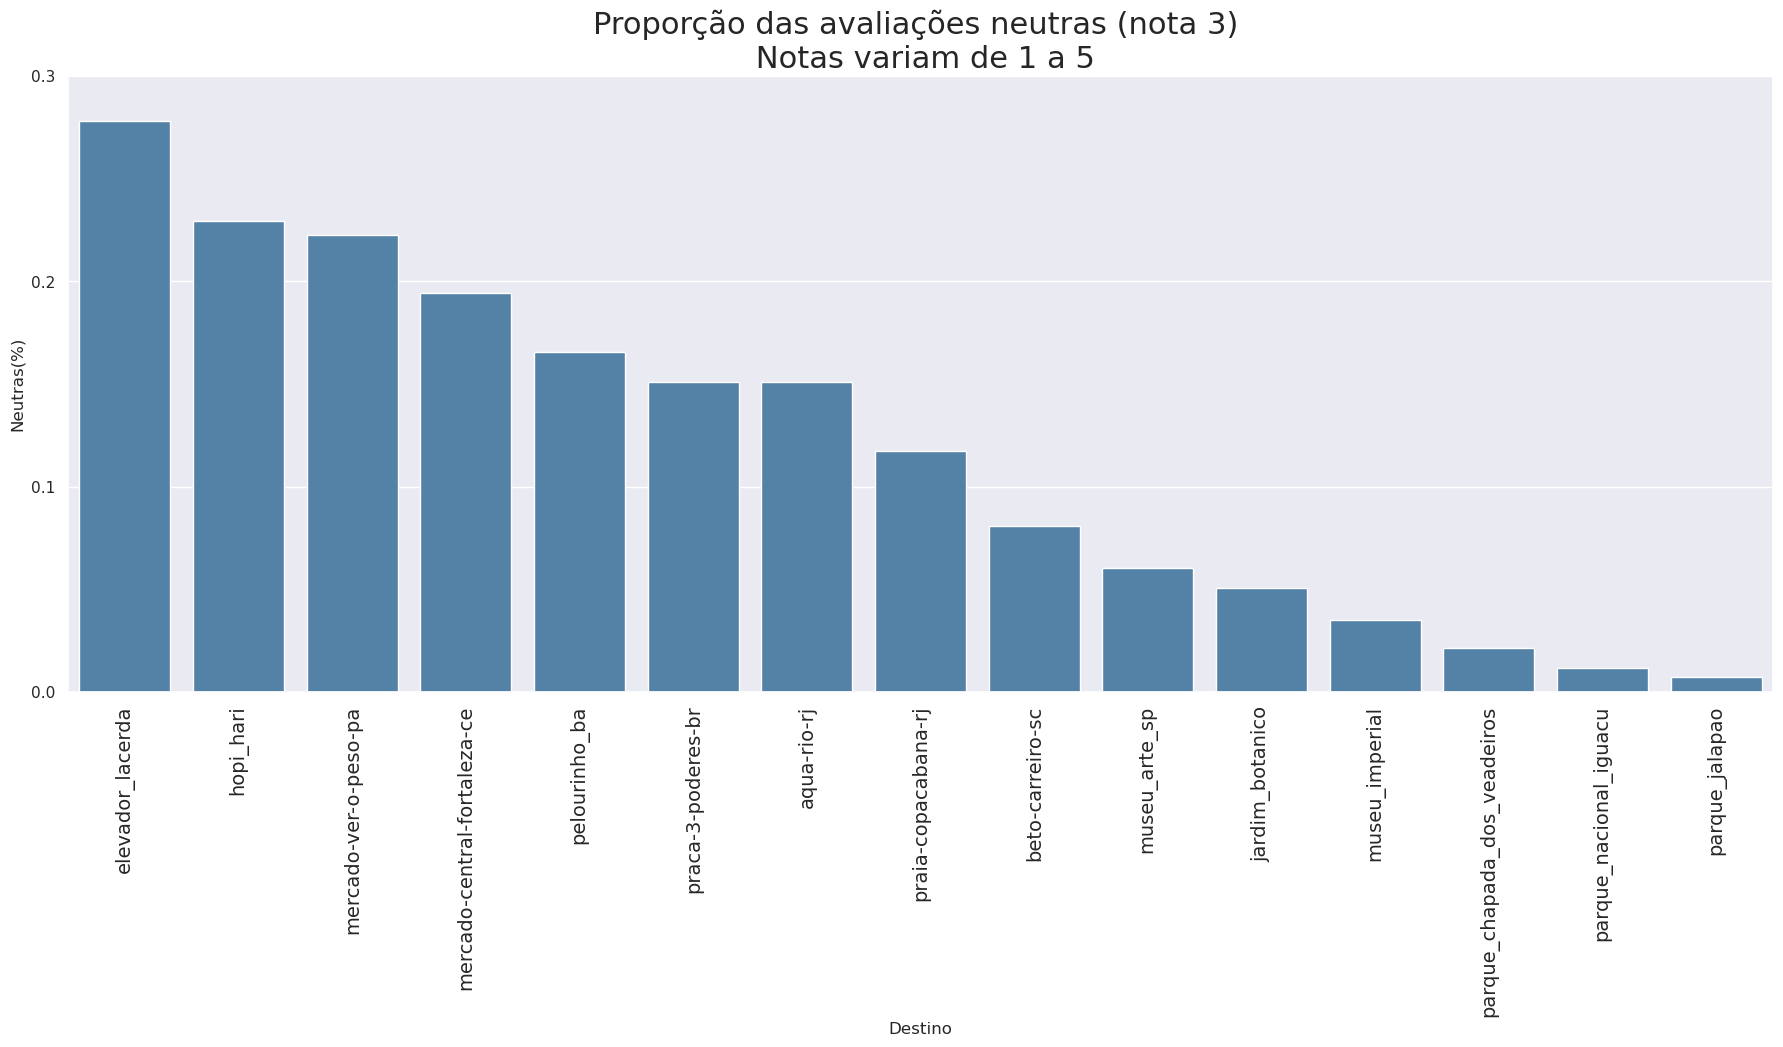

In [115]:
# Criação de gráfico para comparação entre a proporção das avaliações neutras
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações neutras (nota 3) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Neutras(%)'],ascending=False,inplace=True),x=pos_neutra_neg.index,
              y=pos_neutra_neg['Neutras(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.4,0.1))


Text(0.5, 0, 'Destino')

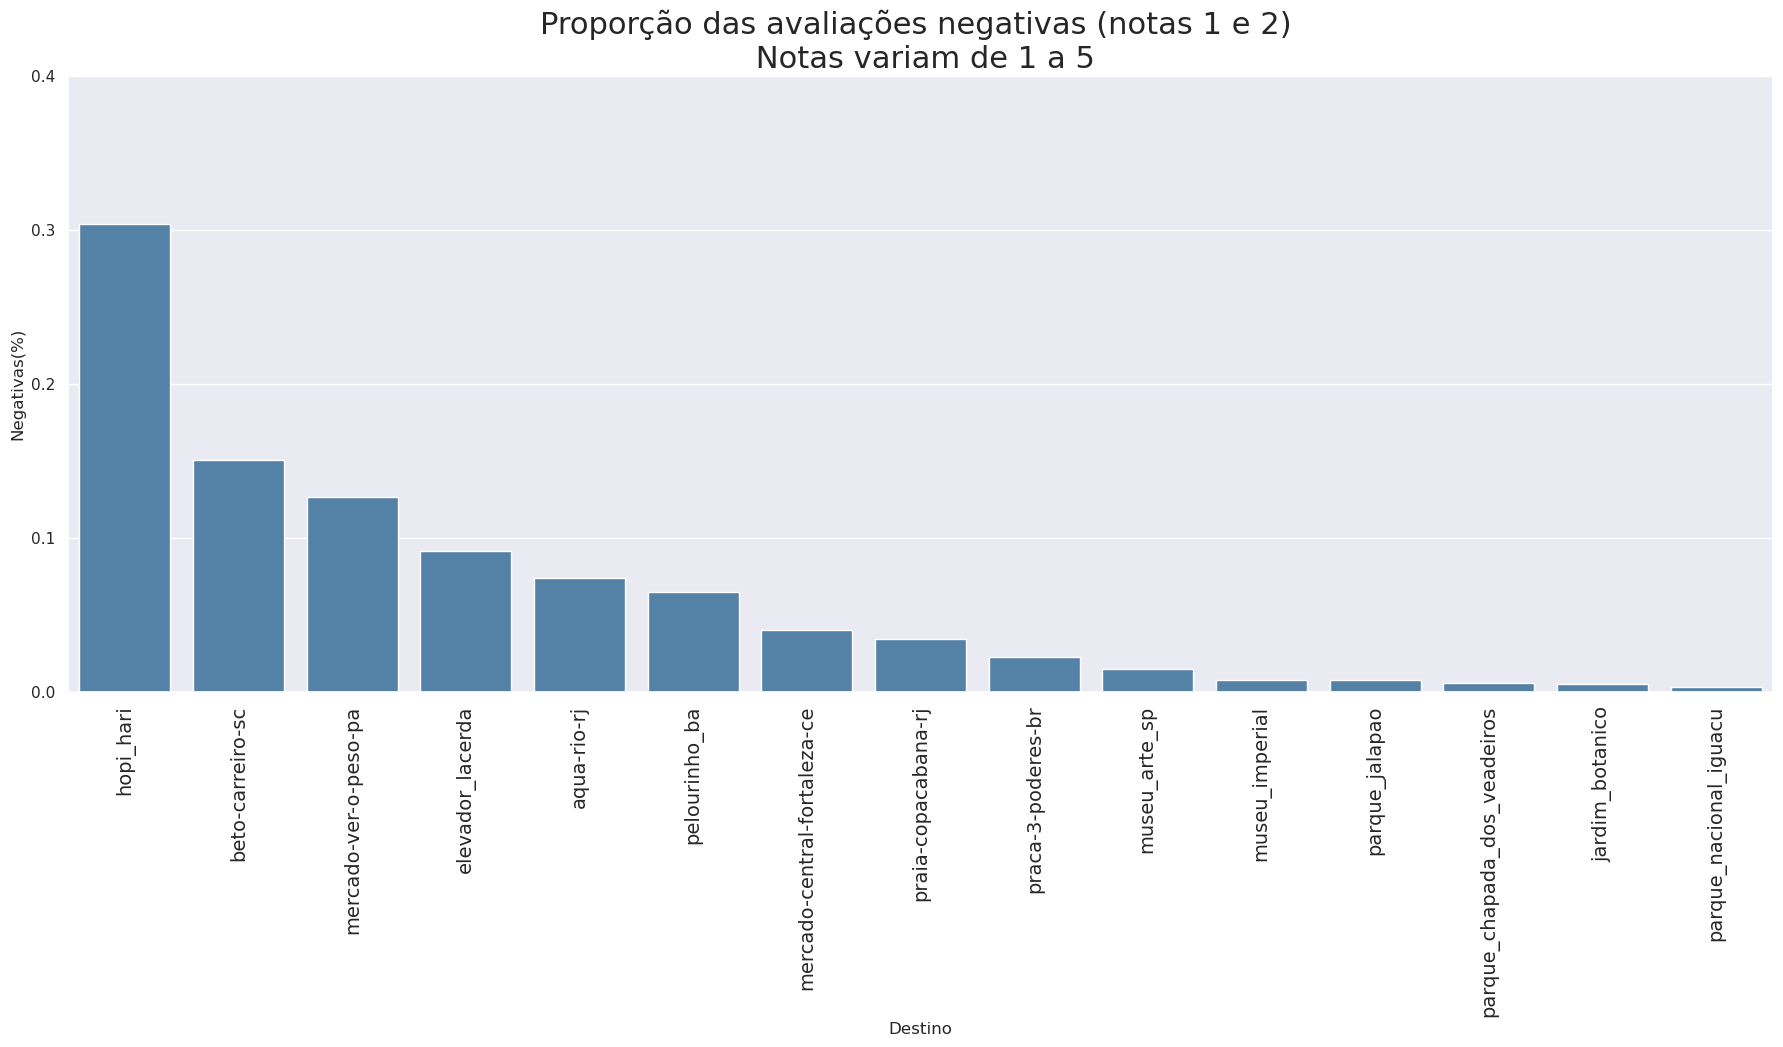

In [116]:
# Criação de gráfico para comparação entre a proporção das avaliações negativas
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações negativas (notas 1 e 2) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Negativas(%)'],ascending=False,inplace=True),
              x=pos_neutra_neg.index,y=pos_neutra_neg['Negativas(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.5,0.1))
plt.xlabel('Destino')

In [117]:
'''
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
row_subplot=0    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))

col_subplot=0
for atracao in nome_atracoes:
    notas_atracao=dados[atracao]
    notas_atracao=notas_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    notas_atracao.reset_index(inplace=True)
    ax=sns.barplot(notas_atracao,x='nota',y='Proporção de Avaliações',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, atracao)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao['Número_de_Avaliações'].sum()))
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])
'''

'\n#Plotar graficos com as proporções das avaliações para cada atração\nfig,axs=plt.subplots(8,2,figsize=(16,40))\nrow_subplot=0    #x=dados[nome_atracao].groupby(\'nota\').agg(Total=(\'nota\',\'count\'))\n\ncol_subplot=0\nfor atracao in nome_atracoes:\n    notas_atracao=dados[atracao]\n    notas_atracao=notas_atracao.groupby(\'nota\').agg(Número_de_Avaliações=(\'nota\',\'count\'))\n    notas_atracao[\'Proporção de Avaliações\']=notas_atracao[\'Número_de_Avaliações\']/notas_atracao[\'Número_de_Avaliações\'].sum()\n    notas_atracao.reset_index(inplace=True)\n    ax=sns.barplot(notas_atracao,x=\'nota\',y=\'Proporção de Avaliações\',ax=axs[row_subplot,col_subplot],color=\'steelblue\')\n    ax.text(-0.45, 0.95, atracao)\n    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao[\'Número_de_Avaliações\'].sum()))\n    ax.set_ylim(0,1)\n    row_subplot+=1\n    if row_subplot>7:\n        row_subplot=0\n        col_subplot=1\nfig.delaxes(axs[7][1])\n'

### Evolução anual da nota média de cada destino

In [118]:
nomes_destinos

['parque_chapada_dos_veadeiros',
 'mercado-ver-o-peso-pa',
 'beto-carreiro-sc',
 'pelourinho_ba',
 'praia-copacabana-rj',
 'museu_imperial',
 'praca-3-poderes-br',
 'museu_arte_sp',
 'jardim_botanico',
 'elevador_lacerda',
 'aqua-rio-rj',
 'parque_jalapao',
 'parque_nacional_iguacu',
 'mercado-central-fortaleza-ce',
 'hopi_hari']

In [119]:
#Criaçao de uma coluna com o ano que cada avaliação
for nome_destino in nomes_destinos:
    dados[nome_destino]['ano']=dados[nome_destino]['data'].apply(lambda x:x.split(' ')[-1])
    dados[nome_destino]=dados[nome_destino].astype({'ano':'int'})

/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

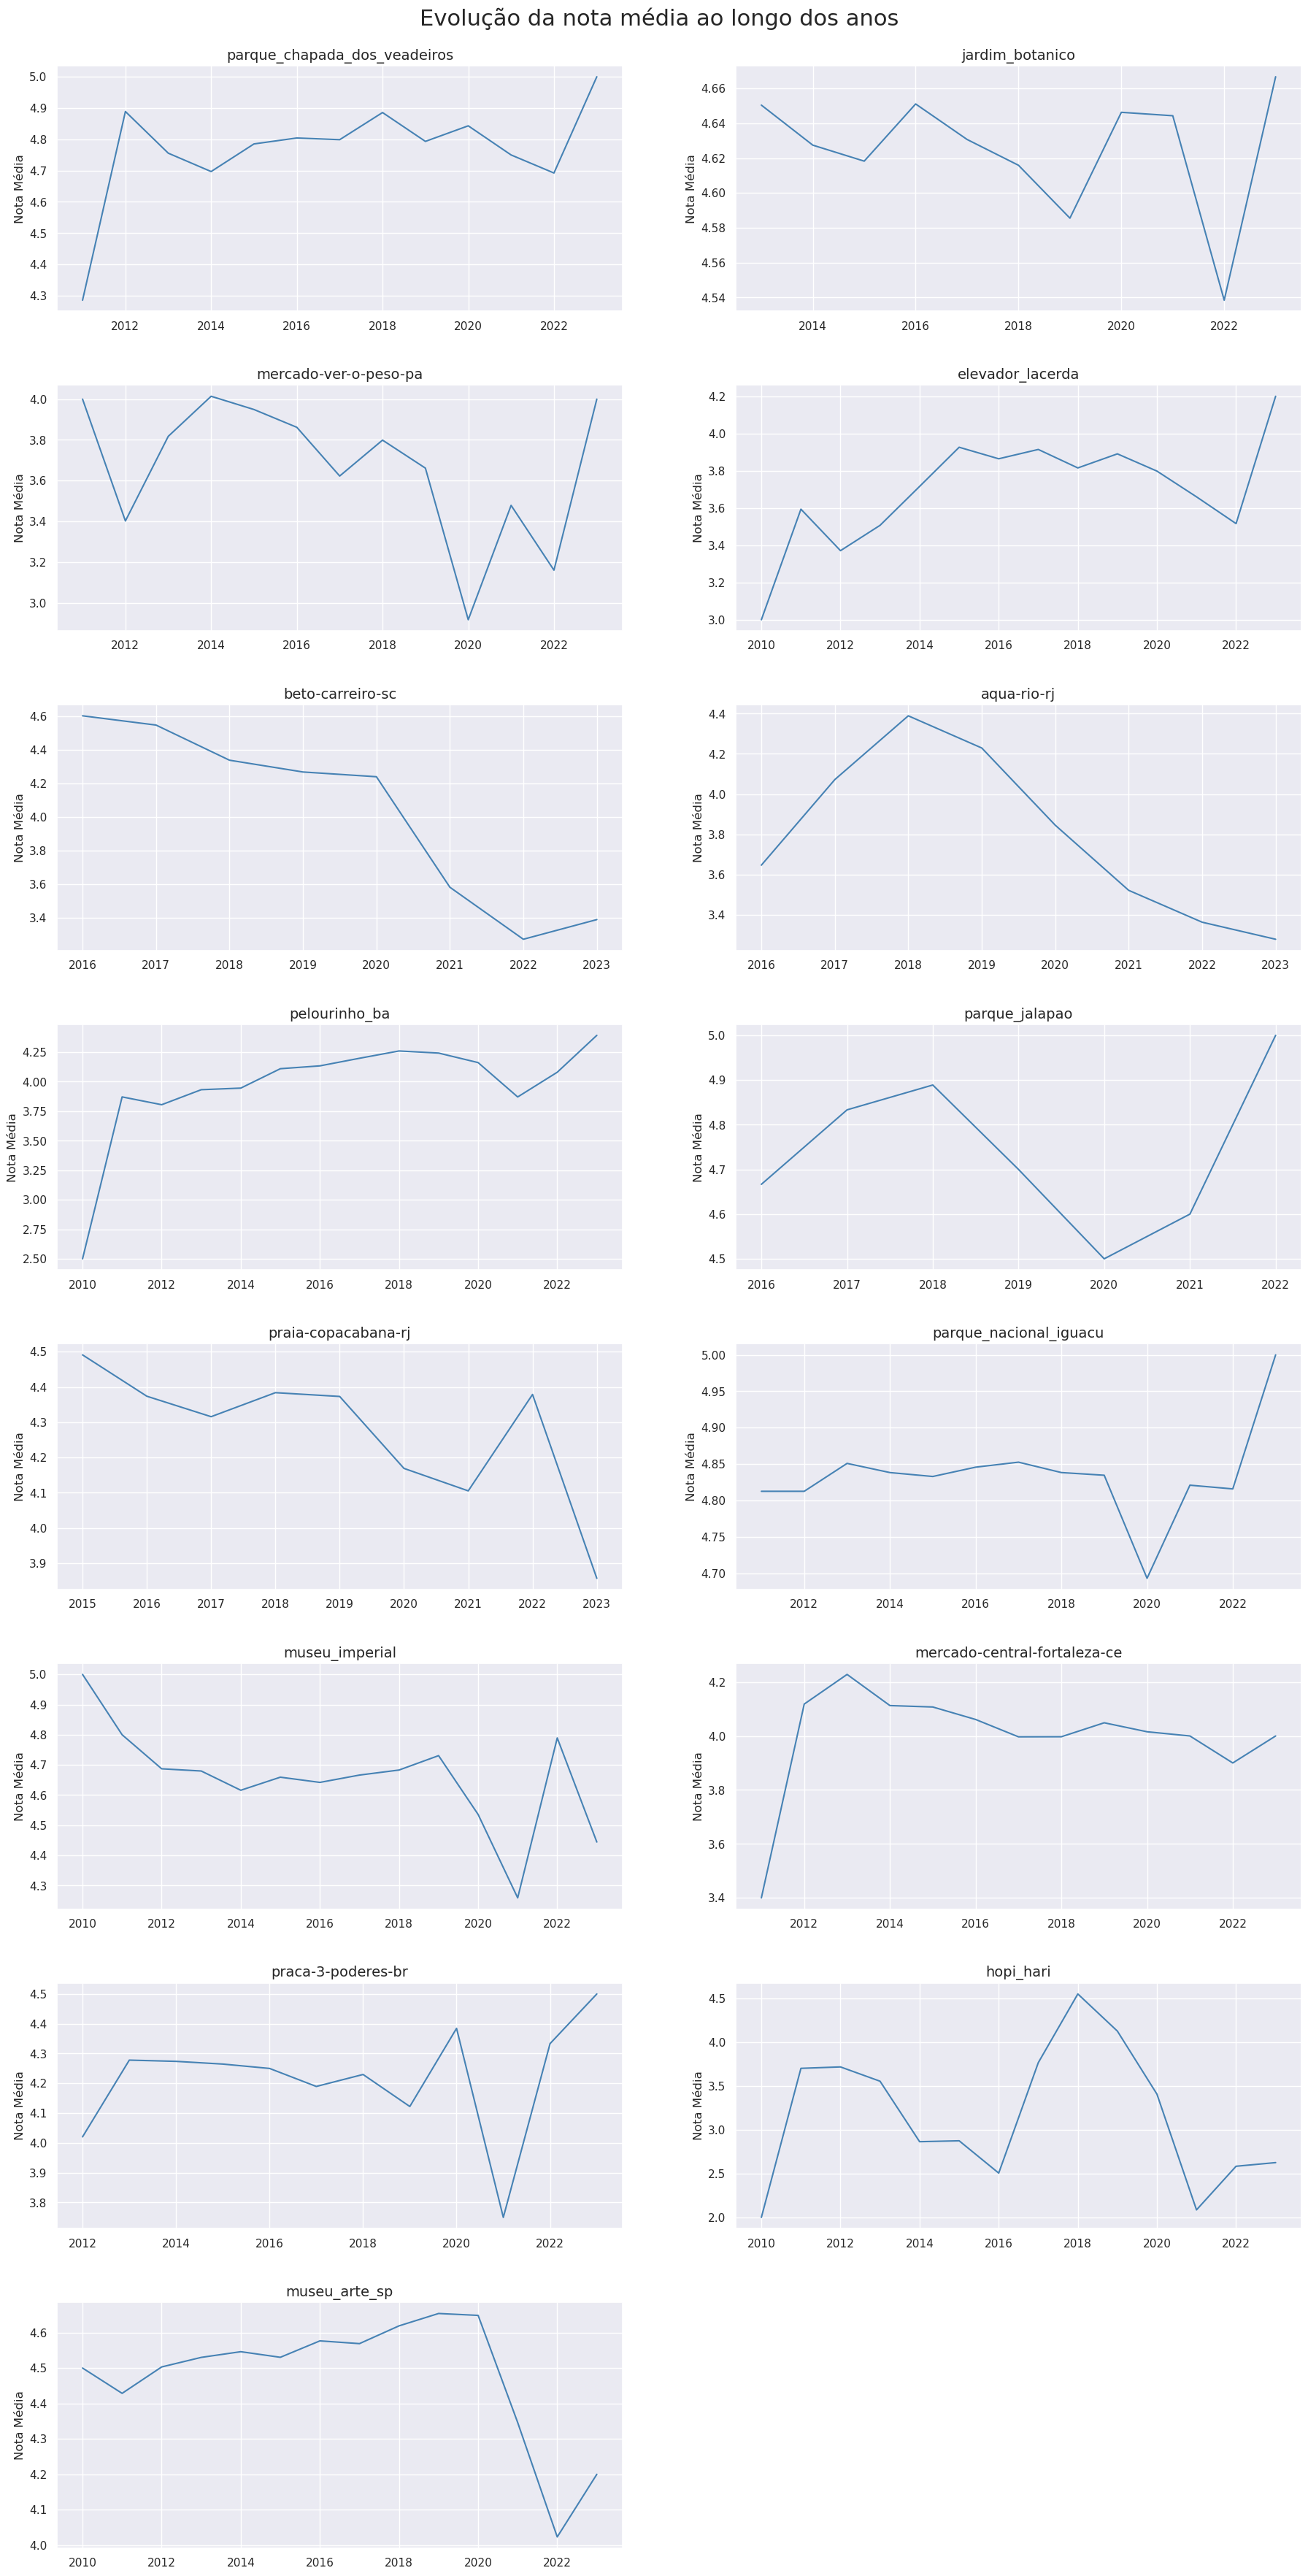

In [120]:
#Plotar graficos com as proporções das avaliações para cada destino
fig,axs=plt.subplots(8,2,figsize=(22,40))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.subplots_adjust(top=0.96) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Evolução da nota média ao longo dos anos', fontsize=22) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
row_subplot=0
col_subplot=0
for nome_destino in dados.keys():
    destino_nota_media=dados[nome_destino].groupby('ano').agg(Nota_Media=('nota','mean'))
    destino_nota_media.reset_index(inplace=True)
    ax=sns.lineplot(destino_nota_media,x='ano',y='Nota_Media',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.set(ylabel='Nota Média')
    ax.set_title(nome_destino, fontsize=14)
    ax.set(xlabel=None)
    #ax.set_ylim(0,5)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1

fig.delaxes(axs[7][1])

# Análise Exploratória - Comentários

##  Dataset

In [121]:
#Agrupar os dados de todos os destinos em um mesmo dataframe
for nome_destino in nomes_destinos:
    dados[nome_destino]['destino']=nome_destino
df_dados=pd.concat([dados[destino] for destino in nomes_destinos],axis=0)
df_dados.reset_index(inplace=True,drop=True)


In [122]:
#Inputs do modelos são os comentários e outputs são as notas
df_x=df_dados[['comentario']].copy()
df_y=df_dados[['nota']].copy()
del df_dados

In [123]:
#Dataset desbalanceado, são poucas avaliações com 1 ou 2 estrelas
df_y.value_counts()

nota
5.0     58040
4.0     26829
3.0     10902
2.0      2974
1.0      2400
Name: count, dtype: int64

In [124]:
#Aproximadamente 57% das avaliações receberam nota 5
df_y.value_counts()/len(df_y)

nota
5.0     0.573830
4.0     0.265253
3.0     0.107786
2.0     0.029403
1.0     0.023728
Name: count, dtype: float64

In [125]:
proporcao_notas_negativas=100*(df_y.value_counts()[3:].sum())/len(df_y)
print('Proporção das avaliações com notas 1 ou 2: {}%'.format(proporcao_notas_negativas))

Proporção das avaliações com notas 1 ou 2: 5.313164269118592%


In [126]:
#O conjunto de dados será dividido em treino, validação e teste
#separacao treino, validação e teste
x_treino,x_val,y_treino,y_val    =train_test_split(df_x,df_y,test_size=0.2,stratify=df_y,random_state=42)
x_treino,x_teste,y_treino,y_teste=train_test_split(x_treino,y_treino,test_size=0.2,stratify=y_treino,random_state=42)


In [127]:
#Aplicação de one hot encoding nas notas
encoder=OneHotEncoder()
y_treino_encoded=encoder.fit_transform(y_treino)
y_val_encoded   =encoder.fit_transform(y_val)
y_teste_encoded =encoder.fit_transform(y_teste)

In [128]:
#A separação dos dados de treino e teste foi feito de modo estratificado, de modo que a propoção de amostras de cada classe foi mantida após a separação
proporcao_treino_teste=pd.concat((df_y.value_counts()/len(df_y),
                        y_treino.value_counts()/len(y_treino),
                        y_val.value_counts()/len(y_val),
                        y_teste.value_counts()/len(y_teste)),axis=1)
proporcao_treino_teste.columns=['Total','Treino','Validação','Teste']
proporcao_treino_teste

,Total,Treino,Validação,Teste
nota,,,,
5.0,0.573830,0.573827,0.573830,0.573838
4.0,0.265253,0.265247,0.265263,0.265262
3.0,0.107786,0.107798,0.107766,0.107761
2.0,0.029403,0.029398,0.029413,0.029412
1.0,0.023728,0.023729,0.023728,0.023727


In [129]:
#Numero de amostras de cada nota nos dados de treino e teste
amostras_treino_teste=pd.concat((y_treino.value_counts(),y_val.value_counts(),y_teste.value_counts()),axis=1)
amostras_treino_teste.columns=['Treino','Validação','Teste']
amostras_treino_teste

,Treino,Validação,Teste
nota,,,
5.0,37145,11608,9287
4.0,17170,5366,4293
3.0,6978,2180,1744
2.0,1903,595,476
1.0,1536,480,384


In [130]:
#Apagar dataframes quenão serão mais usados
del df_x,df_y


## Tamanho dos Comentários

O tamanho dos comentários pode ser avaliado tanto pelo número de palavras quanto pelo número de caracteres. Essa análise é importante porque alguns dos modelos que serão implementados necessitam receber inputs com o mesmo comprimento.

### Número de Palavras em cada Comentário

In [131]:
tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
x_treino['tokens']     =x_treino['comentario'].apply(lambda x:x.lower())          #letras minúsculas
x_treino['tokens']     =x_treino['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
x_treino['num_words']  =x_treino['tokens'].apply(lambda x:len(x))

In [132]:
#75% dos comentários tem menos de 45 palavras (tokens)
x_treino.describe()

,num_words
count,64732.000000
mean,39.976781
std,38.291693
min,0.000000
25%,20.000000
50%,29.000000
75%,45.000000
max,1351.000000


<Axes: title={'center': 'Número de palavras nos comentários'}, xlabel='num_words'>

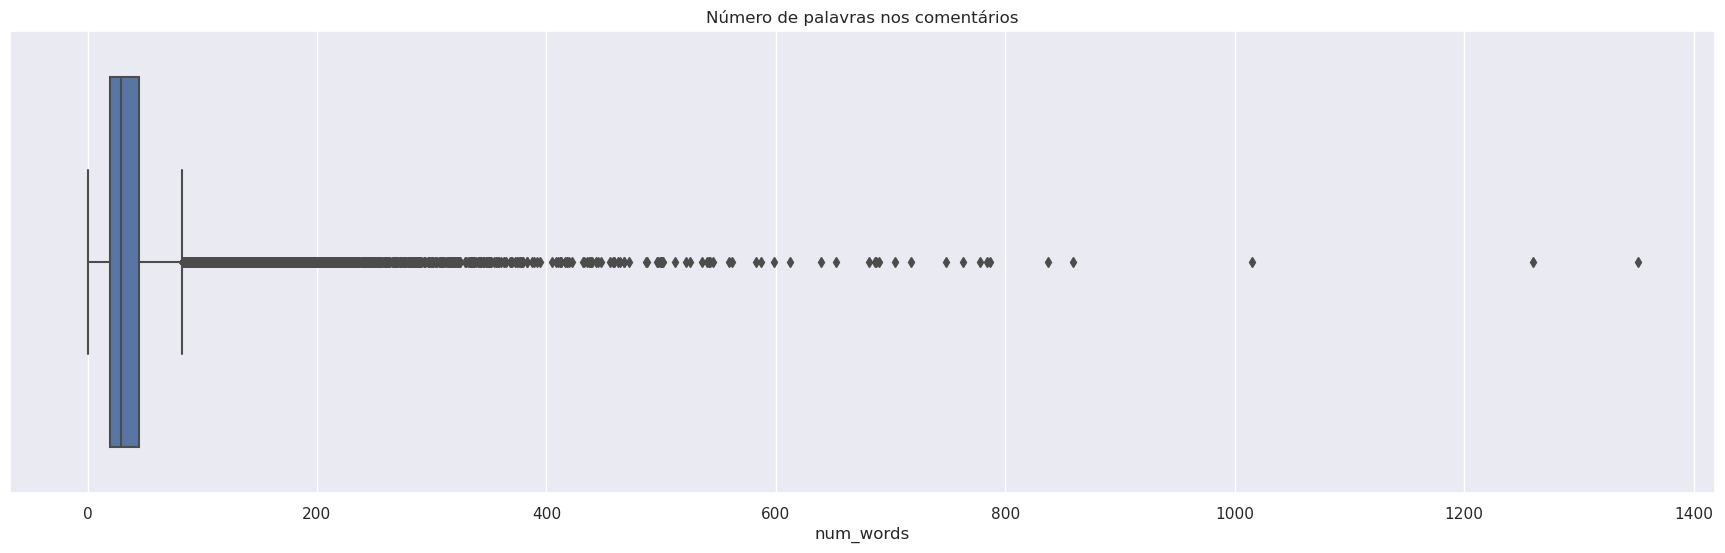

In [133]:
#Número de palavras nos comentários:
#A grande maioria dos comentários tem pequeno número de palavras, 75% deles tem menos de 45 palavras.
#Nota-se a ocorrência de comentário sem nenhum token (provavelmente os caracteres do comentário não foram reconhecidos como token no processo de tokenização)
plt.figure(figsize=[22,6])
plt.title("Número de palavras nos comentários")
sns.boxplot(data=x_treino,x='num_words',orient='h')

In [134]:
#Comentário com 0 tokens
#O comentário sem nenhum token foi escrito em outra lingua, com caracteres desconhecidos
x_treino[x_treino['num_words']==0]

,comentario,tokens,num_words
48076,"남미 최대의 미술관이라는 명성 처럼, 소장하고 있는 작품의 규모와 수준도 뛰어나지만...",[],0


In [135]:
#Remover comentários com 0 tokens
x_treino.drop(x_treino[x_treino['num_words']==0].index,inplace=True)

/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 12.44444444444443, 'Número de Palavras')

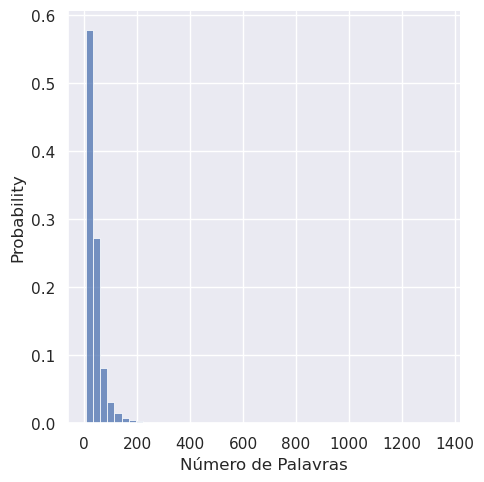

In [136]:
#A grande maioria dos comentários tem pequeno número de palavras, poucos tem mais de 200.

sns.displot(data=x_treino,x='num_words',bins=50,stat='probability' )
plt.xlabel('Número de Palavras')


### Stopwords

Stopwords são palavras que aparecem comenmente em frases e que carregam pouca informação. Esse tipo de palavra é geralmente removido em análises de processamento de linguagem natural.

In [137]:
#stopwords é uma lista com stopwords em lingua portuguesa
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [138]:
#Calcular proporção de stopwords nos comentários
#Razão entre o número de stopwords e o número total de palavras em cada comentário
x_treino['freq_stopwords']=x_treino['tokens'].apply(lambda x:len([word for word in x if word in stopwords])/len(x))

/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Proporção de stopwords nos comentários')

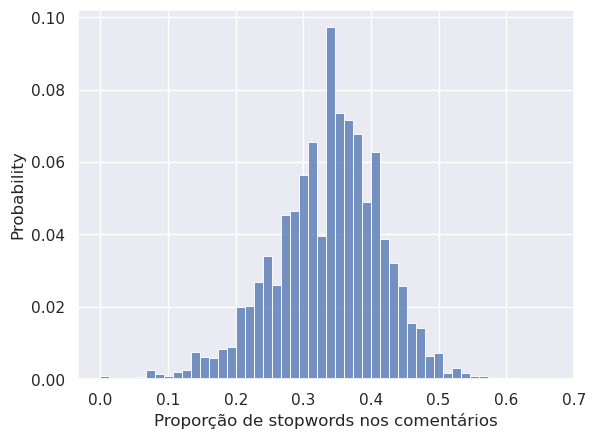

In [139]:
#A maior parte dos comentários tem entre 30 a 40% das palavras compostas de stopwords
sns.histplot(data=x_treino,x='freq_stopwords',bins=50,stat='probability' )
plt.xlabel('Proporção de stopwords nos comentários')

In [140]:
#Remoção de stopwords
x_treino['tokens_no_stowords']=x_treino['tokens'].apply(lambda x:[word for word in x if word not in stopwords])

In [141]:
#Contagem do número de palavras em cada comentário após a remoção das stop words
x_treino['num_words_no_stopwords']  =x_treino['tokens_no_stowords'].apply(lambda x:len(x))

In [142]:
#Antes da remoção das stopwords 75% dos comentários tinham menos de 45 palavras.
#Após a remoção das stopwords 75% dos comentários tem menos de 29 palavras.
x_treino.describe()


,num_words,freq_stopwords,num_words_no_stopwords
count,64731.000000,64731.000000,64731.000000
mean,39.977399,0.335627,25.959633
std,38.291667,0.079154,23.802567
min,6.000000,0.000000,4.000000
25%,20.000000,0.285714,14.000000
50%,29.000000,0.341463,19.000000
75%,45.000000,0.388889,29.000000
max,1351.000000,0.666667,824.000000


/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Semom Stopwords')]

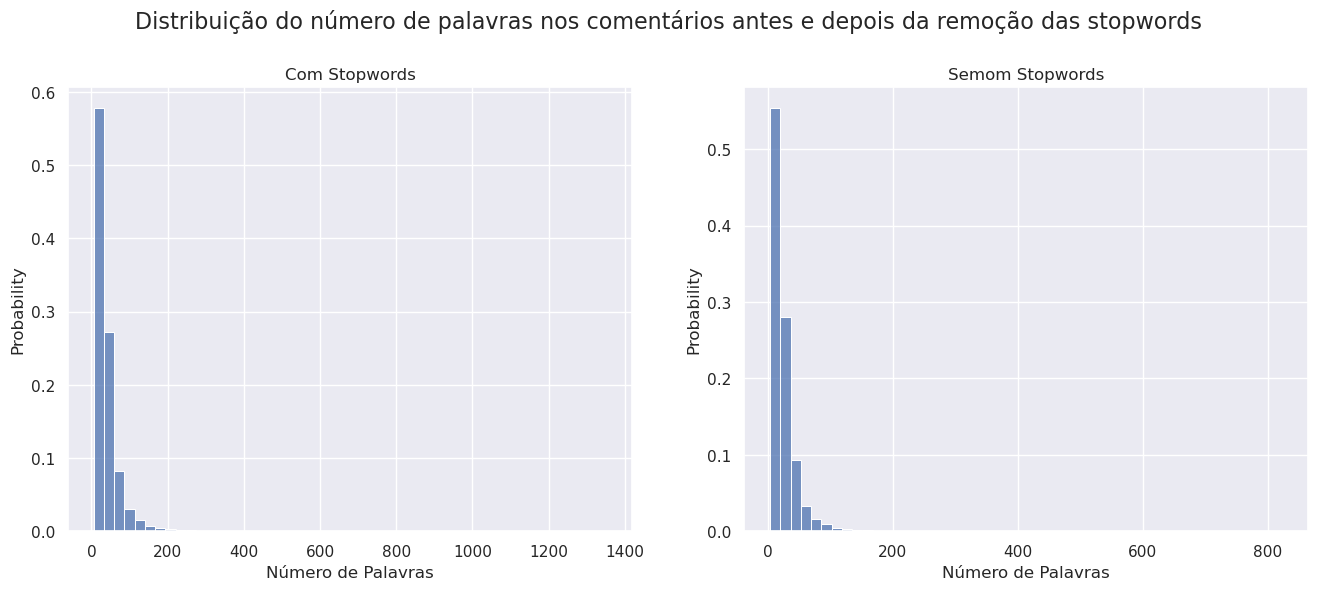

In [143]:
#Distribuição do número de palavras nos comentários antes e depois da remoção das stopwords
fig, axes = plt.subplots(1, 2,figsize=(16,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.subplots_adjust(top=0.85) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Distribuição do número de palavras nos comentários antes e depois da remoção das stopwords', fontsize=16) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
sns.histplot(data=x_treino, x='num_words',bins=50,stat='probability', ax=axes[0])
sns.histplot(data=x_treino, x='num_words_no_stopwords',bins=50,stat='probability' ,ax=axes[1])
axes[0].set(xlabel='Número de Palavras')
axes[0].set(title='Com Stopwords')
axes[1].set(xlabel='Número de Palavras')
axes[1].set(title='Semom Stopwords')




In [144]:
#Remover dos dados de treino as colunas criadas

x_treino=x_treino[['comentario']].copy()

# Pré-processamento dos comentários

Para o pré processamento dos comentários serão usadas duas bibliotecas,são elas NLTK e Spacy. As etapas de pré-processamento aplicadas com essas duas bibliotecas serão praticamente os mesmos com exceção da última. A última etapa do pré-processamento com NLTK será stemming, enquando no caso da Spacy será lemmantization. Isso porque o NLTK não conta com o recurso de lemmantization em ligua portuguesa enquanto o Spacy não conta com stemming para o português.

- STEMMING: consiste em reduzir a palavra ao seu radical. 
  Por exemplo as palavras amigo, amiga e amigão seriam todas reduzidas ao radical amig.

- LEMATIZAÇÃO: consiste em reduzir a palavra àsua forma canônica, levando em conta sua classe gramatical.
  Por exemplo  as palavras propõem, propuseram e propondo serias todas transformarmadas em propor.

## Pré-processamento com NLTK

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Remover acentos e substituir cedillha;
- Stemming.

In [145]:
def preprocess_nltk(dados,remover_acentos=False,coluna='comentario'):
    '''
    Funação recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Remoção pontuação
        -Remoção de stop words;
        -Opcional: remover acentuação e substituir cedilha (caracteres presentes na lingua portuguesa)


    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários; 

    Output:
        -Dataframe com uma única coluna contendo os tokens pré-processados
    '''
    tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
    stopwords = nltk.corpus.stopwords.words('portuguese') #lista de stopwords na lingua portuguesa 
    dados=dados.copy()
    dados['tokens']     =dados[coluna].apply(lambda x:x.lower())          #letras minúsculas
    dados['tokens']     =dados['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
    dados['tokens']     =dados['tokens'].apply(lambda x:[word for word in x if word not in stopwords]) #remover stop words
    dados.drop(coluna,axis=1,inplace=True)
    return dados

In [165]:
#Função que aplica stemming
def stemmming_nltk(dados,coluna='tokens'):
    '''
    Função que aplica stemming na coluna especificada

    Inputs:
        -Dataframe com coluna contendo lista com tokens

    Outputs:
        -Dataframe original com stemming aplicado nos tokens
    '''
    stemmer=nltk.RSLPStemmer()
    dados[coluna]=dados[coluna].apply(lambda x:[stemmer.stem(word) for word in x]) #stemming nos tokens
    return dados

## Pré-processamento com Spacy

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Lemmantization.

In [147]:
def lemmantizar(dados,remover_acentos=False,coluna='comentario'):
    '''
    Função recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Somente palavras nos comentários (remoção de pontuação, números, etc)
        -Remoção de stop words;
        -lemmantization;
        
    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários; 

    Output:
        -Dataframe com uma única coluna contendo em cada linha uma lista de tokens pré-processados
    '''
    dados=dados.copy()
    nlp=spacy.load("pt_core_news_lg")
    dados['tokens']=dados[coluna].apply(lambda x:x.lower()) #letras minúsuculas
    dados['tokens']=dados['tokens'].apply(lambda x: [token.lemma_ for token in nlp(x) if token.is_alpha and not token.is_stop]) #manutenção somente de palavras nos tokens
                                                                                                                                #e remoção de stopwords
    dados.drop(coluna,axis=1,inplace=True) #mantém somente a coluna com os tokens criados
    return dados

### Pipelines de pré-processamento


Serão criadas pipeline de pré-processamento dos comentários que contarão com as seguites etapas:

- Pré-processamento com biblioteca NLTK ou Spacy;
- Opcional: remoção de acentuação e substituição de cedilha;
- Padroninação do número de palavras nos comentários.
- Undersampling nos dados de treino para igualar o número de amostras com cada nota.

In [148]:
def acentos_cedilha(dados, coluna='tokens'):
    '''
    Função para remover acentuação e substituir a cedilha pela letra c
    '''
    dados[coluna]=dados[coluna].apply(lambda x:[normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII') for word in x]) 


In [149]:
def padronizar_num_tokens(dados,num_words=25,coluna='tokens'):
    '''
    Função para padranizar o número de palavras nos comentários.
    Comentários com número de palavras maior que o especificado serão truncados, enquanto aos com número maior será aplicado padding

    inputs-
    dados     - dataframe com coluna contendo os tokens dos comentátios
    coluna    - coluna com tokens
    max_words - número máximo de palavras em cada comentário

    outputs-
    Dataframe com todos os comentários com mesmo número de tokens;
    Cada comentário no formato [1,num_words]
    '''
    dados[coluna]=dados[coluna].apply(lambda x: [x[:num_words]if len(x)>num_words else x+(num_words-len(x))*['pad']])
    dados[coluna]=dados[coluna].apply(lambda x:np.array(x).reshape([1,-1]))
    dados=np.array(dados[coluna])
    dados=np.concatenate(dados,axis=0)
    return dados

In [150]:
#Aplicação de undersampling de forma randômica
undersampler=RandomUnderSampler(random_state=42)

In [166]:
# Pipeline com NLTK
pipeline_treino_NLTK=make_pipeline(
            FunctionTransformer(preprocess_nltk),
            FunctionTransformer(stemmming_nltk),
            FunctionTransformer(padronizar_num_tokens),
            undersampler) 

pipeline_val_teste_NLTK=make_pipeline(
            FunctionTransformer(preprocess_nltk),
            FunctionTransformer(stemmming_nltk),
            FunctionTransformer(padronizar_num_tokens)) 

In [162]:
# Pipeline com Spacy
pipeline_treino_Spacy=make_pipeline(
            FunctionTransformer(lemmantizar),
            FunctionTransformer(padronizar_num_tokens),
            undersampler) 

pipeline_val_teste_NLTK=make_pipeline(
            FunctionTransformer(lemmantizar),
            FunctionTransformer(padronizar_num_tokens)) 

In [172]:
x_treino_lemman,y_treino_lemman=pipeline_treino_Spacy.fit_resample(x_treino,y_treino_encoded)

In [ ]:
np.save('x_treino_lemman.npy',x_treino_lemman)
np.save('y_treino_lemman.npy',y_treino_lemman)

### Análise da frequência que cada palavra aparece nos comentários com cada nota

O número de comentários com cada nota é muito diferente, dificultando a comparação da frequência de aparição de cada palavra em comentários com notas diferentes. Para solucionar essa dificuldade serão selecionados de forma aleatória do conjunto de dados de treino número igual de comentários com cada nota


In [64]:
#Selecionar de forma aleatória número igual de comentários com cada nota
#x_res_pp são os dados amsotrados com pré processamento
#x_res são os dados amostrados sem o pré processamento (serão mantidos para visualização de exemplos de comentários)

resampler=RandomUnderSampler(random_state=42)
x_res_pp,y_res=resampler.fit_resample(x_treino_pp,y_treino)
x_res,_=resampler.fit_resample(x_treino,y_treino)

In [65]:
#Comparar o número de amostras antes e depois do processo de undersampling
amostras_original_resampled=pd.concat((y_treino.value_counts(),y_res.value_counts()),axis=1)
amostras_original_resampled.columns=['Original',"Resampled"]
amostras_original_resampled

,Original,Resampled
nota,,
1.0,1536,1536
2.0,1903,1536
3.0,6978,1536
4.0,17170,1536
5.0,37145,1536


In [66]:
#Contar o número de vezes que cada palavra aparece nos comentários com a mesma nota e também o número total de vezes que cada palavra aparece
#Para essa contagem serão usados os dados com mesmo número de amostras de cada nota
nota1_count=Counter()
nota2_count=Counter()
nota3_count=Counter()
nota4_count=Counter()
nota5_count=Counter()
total_count=Counter()

In [67]:
for num_row in range(len(x_res)):
    if y_res.iloc[num_row,0]==1:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota1_count[palavra]+=1
            total_count[palavra]+=1

    elif y_res.iloc[num_row,0]==2:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota2_count[palavra]+=1
            total_count[palavra]+=1

    elif y_res.iloc[num_row,0]==3:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota3_count[palavra]+=1
            total_count[palavra]+=1

    elif y_res.iloc[num_row,0]==4:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota4_count[palavra]+=1
            total_count[palavra]+=1

    else:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota5_count[palavra]+=1
            total_count[palavra]+=1

In [68]:
#Palavras mais comuns nos comentários com nota 1
nota1_count.most_common()

[('e', 2990),
 ('de', 2567),
 ('o', 1748),
 ('a', 1530),
 ('que', 1482),
 ('nao', 1296),
 ('para', 1009),
 ('', 958),
 ('um', 903),
 ('parque', 849),
 ('em', 844),
 ('com', 838),
 ('no', 797),
 ('do', 657),
 ('brinquedos', 533),
 ('uma', 525),
 ('mais', 495),
 ('na', 465),
 ('os', 461),
 ('as', 454),
 ('filas', 449),
 ('muito', 427),
 ('se', 419),
 ('da', 399),
 ('fila', 367),
 ('por', 350),
 ('sem', 330),
 ('tem', 318),
 ('ao', 312),
 ('dia', 307),
 ('foi', 278),
 ('mas', 277),
 ('ir', 272),
 ('lugar', 260),
 ('pra', 254),
 ('horas', 249),
 ('dos', 244),
 ('fui', 232),
 ('pessoas', 219),
 ('atracoes', 213),
 ('esta', 207),
 ('ja', 207),
 ('so', 203),
 ('local', 196),
 ('estava', 196),
 ('nos', 190),
 ('ser', 184),
 ('la', 181),
 ('minha', 181),
 ('sao', 176),
 ('tudo', 168),
 ('como', 167),
 ('ou', 158),
 ('ate', 151),
 ('voce', 151),
 ('das', 151),
 ('3', 150),
 ('mal', 149),
 ('2', 149),
 ('me', 146),
 ('era', 144),
 ('nada', 142),
 ('experiencia', 141),
 ('brinquedo', 140),
 ('eu',

In [69]:
#Palavras mais comuns nos comentários com nota 5

nota5_count.most_common()

[('e', 3144),
 ('de', 1865),
 ('a', 1557),
 ('o', 1413),
 ('para', 942),
 ('que', 834),
 ('com', 808),
 ('um', 800),
 ('muito', 771),
 ('', 694),
 ('do', 657),
 ('da', 520),
 ('uma', 500),
 ('nao', 434),
 ('em', 432),
 ('bem', 426),
 ('lugar', 420),
 ('no', 395),
 ('as', 374),
 ('parque', 370),
 ('os', 368),
 ('mais', 298),
 ('tem', 279),
 ('se', 246),
 ('vale', 239),
 ('na', 234),
 ('lindo', 231),
 ('local', 231),
 ('passeio', 222),
 ('ao', 210),
 ('pena', 208),
 ('sao', 206),
 ('dos', 193),
 ('mas', 189),
 ('por', 180),
 ('jardim', 166),
 ('das', 164),
 ('cidade', 155),
 ('quem', 155),
 ('museu', 154),
 ('ir', 150),
 ('visita', 149),
 ('cuidado', 148),
 ('conhecer', 148),
 ('como', 147),
 ('visitar', 145),
 ('pra', 140),
 ('curitiba', 135),
 ('tudo', 127),
 ('familia', 127),
 ('dia', 125),
 ('bom', 125),
 ('historia', 122),
 ('voce', 117),
 ('la', 115),
 ('todos', 115),
 ('sempre', 114),
 ('natureza', 112),
 ('praia', 109),
 ('ser', 105),
 ('fotos', 103),
 ('excelente', 103),
 ('otim

In [70]:
#Palavras menos comuns nos comentários com nota 5
nota5_count.most_common()[-1:-20:-1]

[('adorou', 1),
 ('plantasarvores', 1),
 ('onibusas', 1),
 ('nacuional', 1),
 ('itau', 1),
 ('ga', 1),
 ('farinhas', 1),
 ('hortifruti', 1),
 ('mudas', 1),
 ('latinaartesanato', 1),
 ('procuro', 1),
 ('viajo', 1),
 ('abertaleve', 1),
 ('aguentar', 1),
 ('cataras', 1),
 ('laterais', 1),
 ('castelos', 1),
 ('jardinagem', 1),
 ('familiarbom', 1)]

In [71]:
#Palavras menos comuns nos comentários com nota 1
nota1_count.most_common()[-1:-20:-1]

[('despistar', 1),
 ('falamos', 1),
 ('poderpublico', 1),
 ('irregularidades', 1),
 ('respeitar', 1),
 ('diminuidos', 1),
 ('ridiculos', 1),
 ('cristo', 1),
 ('250', 1),
 ('feias', 1),
 ('gordurosas', 1),
 ('porcoes', 1),
 ('marcacoes', 1),
 ('lotadosistema', 1),
 ('mijo', 1),
 ('congestionado', 1),
 ('legalzinho', 1),
 ('surfpreco', 1),
 ('surf', 1)]

Comparando os comentários com nota 1 e os comentários com nota 5, é possível notar que as palavras mais frequentes em ambos se repetem, são preposições e artigos como por exemplo e,a,que,de,do. Esse tipo de palavra aparece  em frequentemente em todo tipo de frase e não serve para caracterizar um  comentário. Deve-se buscar palavras que aparecem com maior frequência em comentários com determinada nota, espera-se por exemplo que uma palavra como excelente apareça com maior frequência em comentários com nota 5.

Já verificando as palavras que aparecem com menor frequência, verifica-se a ocorrência de palavras incomuns, com grafia errada e com erros de digitação. Palavras que aparecem raramente não podem ser empregadas para caracterizar um conjunto de comentários.



Para comparar as palavras que aparecem com maior frequência em cada nota, será calculada a razão entre o número de vezes que cada palavra aparece em comentários com certa
nota e o número de vezes em que a palavra apareceu em todos os comentários. Por exemplo, caso a palavra excelente apareça somente em comentários com nota 5, a razão para essa 
palavra será 1 para nota 5 e 0 para os demais. Ou seja, palavram que apareçam com maior frequência em comentários com certa nota terão razao mais próximas de 1.



In [72]:
#Palavras raras serão desconsideradas no cálculo das razões
def calcular_razao(counter_nota,counter_total,min_freq):
    '''
    Função para calcular a razão entre o numero de vezes que a palavra aparece em comentários com certa nota e o nḿero de vezes que a palavra aparece em 
    todos os comentários

    inputs:
    counter_nota  - objeto Counter com número de vezes que as palavras aparerem em comentários com certa nota
    counter_total - objeto Counter com número de vezes que as palavras aparerem no conjunto de todos os comentrários
    min_freq      - número mínimo de vezes que uma palavra deve aparecer para ser consideradas. Palavras raras não são úteis para caracterizar os comentários
    '''
    razao=Counter()
    for palavra in counter_nota:
        if counter_nota[palavra]>min_freq:
            razao[palavra]=counter_nota[palavra]/counter_total[palavra]
    return razao
    

min_freq=100 #Palavra deve ter aparecido no mínimo cem vezes para ser considerada

razao_nota5=calcular_razao(nota5_count,total_count,min_freq)
razao_nota4=calcular_razao(nota4_count,total_count,min_freq)
razao_nota3=calcular_razao(nota3_count,total_count,min_freq)
razao_nota2=calcular_razao(nota2_count,total_count,min_freq)
razao_nota1=calcular_razao(nota1_count,total_count,min_freq)

In [46]:
razao_nota5.most_common()

[('natureza', 0.6292134831460674),
 ('excelente', 0.4951923076923077),
 ('curitiba', 0.47368421052631576),
 ('lindo', 0.4647887323943662),
 ('jardim', 0.39712918660287083),
 ('museu', 0.3938618925831202),
 ('familia', 0.3735294117647059),
 ('otimo', 0.3543859649122807),
 ('passeio', 0.31805157593123207),
 ('visitar', 0.30851063829787234),
 ('historia', 0.30730478589420657),
 ('fotos', 0.3020527859237537),
 ('bem', 0.29379310344827586),
 ('lugar', 0.2673456397199236),
 ('sempre', 0.2579185520361991),
 ('cuidado', 0.252991452991453),
 ('quem', 0.25080906148867316),
 ('pena', 0.24615384615384617),
 ('conhecer', 0.24104234527687296),
 ('vale', 0.23971915747241726),
 ('visita', 0.2395498392282958),
 ('todos', 0.23138832997987926),
 ('muito', 0.22973778307508938),
 ('das', 0.22937062937062938),
 ('bom', 0.21853146853146854),
 ('praia', 0.21372549019607842),
 ('da', 0.20816653322658127),
 ('com', 0.20638569604086845),
 ('cidade', 0.20025839793281655),
 ('para', 0.19748427672955976),
 ('e', 0.

In [47]:
razao_nota1.most_common()

[('horrivel', 0.7894736842105263),
 ('brinquedo', 0.6222222222222222),
 ('horas', 0.6163366336633663),
 ('3', 0.5338078291814946),
 ('fila', 0.532656023222061),
 ('filas', 0.5202780996523755),
 ('experiencia', 0.5108695652173914),
 ('2', 0.49174917491749176),
 ('lotado', 0.4721030042918455),
 ('brinquedos', 0.46347826086956523),
 ('entrar', 0.4423791821561338),
 ('nem', 0.4370860927152318),
 ('era', 0.4311377245508982),
 ('ingresso', 0.4185185185185185),
 ('minha', 0.40765765765765766),
 ('mal', 0.3941798941798942),
 ('estao', 0.37969924812030076),
 ('parque', 0.37351517817861857),
 ('caro', 0.3707482993197279),
 ('sem', 0.3662597114317425),
 ('fomos', 0.3633633633633634),
 ('falta', 0.3619631901840491),
 ('anos', 0.3612040133779264),
 ('sujo', 0.3581081081081081),
 ('dia', 0.34689265536723163),
 ('me', 0.34679334916864607),
 ('foi', 0.3349397590361446),
 ('fui', 0.33429394812680113),
 ('ir', 0.31738623103850644),
 ('pessoas', 0.31556195965417866),
 ('ja', 0.3141122913505311),
 ('nos',


Analisando as palavras que aparecem com maior frequência nos comentários com nota 5, as três primeiras são espeficas para certos destinos (trilhas,cataretas,natureza). Já a quarta palavra (maravilhoso) é uma palavra que é relacionada a comentários extremamente positivos. Outras exemplos de palavras relacionadas a comentários positivos são lindo, beleza, excelente, etc.

Já para os comentários com nota 1, encontramos palavras como horrível, péssimo, filas, etc.

As palavras incomuns foram eliminadas no cálculo da razão, ja as palavras muito comuns tem razões próximas a 0.2, porque elas não são características para comentários com um nota específica.


In [48]:
#Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
def numero_ocorrencias(palavra):
    '''
    Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
    A contagem será feita no conjunto de dados com mesmo número amostras de cada comentário para possibilitar a comparação

    Input
    palavra (palavra) - A palavra para a qual se deseja exibir a contagem 
    '''
    print('Número de vezes que a palavra {} apareceu nos comentários: '.format(palavra))
    print('')
    print('Nota 5: {}'.format(nota5_count[palavra]))
    print('Nota 4: {}'.format(nota5_count[palavra]))
    print('Nota 3: {}'.format(nota3_count[palavra]))
    print('Nota 2: {}'.format(nota2_count[palavra]))
    print('Nota 1: {}'.format(nota1_count[palavra]))


In [49]:
#Exibindo o número de ocorrências da palavra maravilhoso nos comentários com cada nota
#Interessante notar que a palavra maravilhoso aparece am alguns comentários com notas ruins
numero_ocorrencias('maravilhoso')

Número de vezes que a palavra maravilhoso apareceu nos comentários: 

Nota 5: 88
Nota 4: 88
Nota 3: 8
Nota 2: 6
Nota 1: 8


In [50]:
#Exibindo o número de ocorrências da palavra péssimo nos comentários com cada nota
numero_ocorrencias('pessimo')

Número de vezes que a palavra pessimo apareceu nos comentários: 

Nota 5: 2
Nota 4: 2
Nota 3: 13
Nota 2: 29
Nota 1: 75


In [51]:
#Vamos verificar exemplos de comentarios com as notas e palavras selecionadas
nota_selecionada=1
palavra_selecionada='maravilhoso' 
exemplos=[]
for row_comentario in range(len(y_res)):
    if (y_res.iloc[row_comentario,0]==nota_selecionada) and (palavra_selecionada in x_res_pp.iloc[row_comentario,0].split(' ')):
        exemplos+=[x_res.iloc[row_comentario,0]] 

In [95]:
exemplos[0]

'O Aqua Rio  é maravilhoso e até quero voltar! Mas, as atendentes pior do que os bichos. Tudo de mal humor, estressadas e não educadas, tem uma loirinha nossa, ranço da cara dela ô mulherzinha grossa! Só pelo mal atendimento minha nota nesse momento é 1. '

Os resultados encontrados indicam que a frequência de aparição de palavras em comentários com diferentes notas pode ser usado para identificar
a nota relativa a cada comentário. Ou seja, determinadas palavras aparecem somente em comentários com certas notas.

# Rede Neural Multi Layer Perceptron


Nessa seção será criada uma rede neural que usará as palavras presentes em um comentário para lhe atribuir uma nota. A rede será para classificação e vai receber como input um comentário e gerará como saída umas das cinco notas possíveis.
Conforme verificado no tópico anterior, certas palavras aparecem com maior frequência em comentários com determinada nota. Para selecionar as palavras que serão usadas para caracterizar os comentários será usada a razão entre o número de vezes que a palavra apareceu em comentários com certa notas e o número total de vezes que a palavra apareceu em todos os comentários. Será escolhido um threshold, onde somente as palavras com razão acima desse valor serão usadas pela rede. Lembrando que uma palavra que aparece em todo tipo de comentário tem razão aproximandamente igual a 0.2.

Será criado um vocabulário que conterá todas as palavras que serão usadas para classificar a nota de um comentário. Esse vocabulário será um dicionário em que as chaves serão as palavras selecionadas e os valores serão números que servirão como identificador para cada palavra. As palavras selecionadas para fazer parte do vocabulário serão aquelas em que a razão entre o número de aparições em comentários com certa nota e o número total de aparições supera um threshold especificado.

## Preparação dos dados para a rede

Etapas dos Pré-processamento:

-One hot encode as saídas da rede;
-Restringir o número de caracteres em cada comentário;
-Remover a pontuação dos cometários;
-Transformar todas as letrass dos comentários para minúsculas;
-Remover a acentuação dos comentários;
-Para os dados de treino será testado também a aplicação de amostragem para igualar o número de amostras de comentários com cada nota.


In [100]:
#Criação de um vocabuário 
'''
O vocabulário conterá todas as palavras que serão usadas para classificar a nota de um comentário. É um dicionário em que as chaves são as
palavras selecionadas e os valores são números que servirão como identificador para cada palavra. As palavras selecionadas para fazer parte
do vocabulário são aquelas em que a razão entre o número de aparições em comentários com certa nota e o número total de aparições supera
certo threshold especificado.
'''

threshold=0.3
vocab={}
razoes=[razao_nota1,
        razao_nota2,
        razao_nota3,
        razao_nota4,
        razao_nota5]
num=0
for razao_nota in razoes:
    for palavra in razao_nota.most_common():
        if palavra[1]>threshold and palavra[0] not in vocab.keys():
            vocab[palavra[0]]=num
            num+=1


As entradas da rede neural serão os comentários. Porém as palavras desses cometários deverão ser transformadas em valores numéricos para que possam ser usados pela rede neural. Cada comentário será convertido em um vetor [1,n_palavras] onde n_palavras é o número total de palavras presente no vocabulário criado. Esse vetor terá 0s para indicar que a palavra não está presente no comentário e 1s caso contrário. As posições no vetor que receberão os valores 1 serão os valores das palavras no vocabulário criado. Por exemplo, imagine que a palavra horrivel receba o valor 10 no vocabulário. Caso a palavra horrivel esteja no comentário, o index 10 do vetor receberá o valor 1.

In [99]:
def converter_comentarios(comentarios, vocab):
    '''
    Função que transforma os comentários em entradas nméricas para a rede neural
    
    inputs :

    comentarios - dataframe com os comentários
    vocab       - dicionário com o vacabulário criado, nop qual as palavras são as chaves e os valores um indicador para cada palavra
    '''
    
    x_numerico=np.zeros([len(comentarios),len(vocab)])
    for row_comentario in range(len(comentarios)):
        for word in comentarios.iloc[row_comentario,0].split(' '):
            if word in vocab.keys():
                x_numerico[row_comentario,vocab[word]]+=1
    return x_numerico

### Pipeline

In [74]:
#Função para pré-processamento dos dados que será incluída no pipeline
def truncar_acentuacao_pontuacao_minusculas(dados,max_caracteres=300,coluna='comentario'):
    '''
    Função que recebe os dataframe com coluna=coluna contendo os comentários sem nenhum pré-processamento
    A função retorna os comentários com número especificado de caracteres,sem pontuação,sem acentos e com todas as letras minúsculas

    inputs 
    dados          - dataframame com coluna contendo os comentários
    max caracteres - número máximo de caracteres que será mantido nos comentários
    coluna         - nome da coluna do dataframe que contém os comentarios
    '''
    dados[coluna]=dados[coluna].apply(lambda x:x[:max_caracteres]) #Truncar número de caracteres
    dados[coluna]=dados[coluna].apply(lambda x:x.translate(str.maketrans('','',string.punctuation))) #remover pontuação
    dados[coluna]=dados[coluna].apply(lambda x:x.lower()) #letras todas minúsculas

    #remover acentuação
    dados[coluna]=dados[coluna].apply(lambda x:unicodedata.normalize("NFD",x))
    dados[coluna]=dados[coluna].apply(lambda x:x.encode("ascii", "ignore"))
    dados[coluna]=dados[coluna].apply(lambda x:x.decode("utf-8"))

    return dados

In [58]:
'''
Dados para treino 
x_treino
y_treino

Dados para validação
x_val
y_Val

Dados para teste 
x_teste
y_teste

'''

#One hot encoder
one_hot_enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_treino_encoded=one_hot_enc.fit_transform(y_treino)
y_teste_encoded =one_hot_enc.fit_transform(y_teste)
y_val_encoded   =one_hot_enc.fit_transform(y_val)

#Pipeline de pre_processamento
#A pipeline de treino aplicará o pré-processamento de random undersampling
#O undersampling será aplicado somente sos dados de treinamento. O modelo será avaliados com dados com a propoção original de comnetários com cada nota.
pipeline_treino=make_pipeline(
    FunctionTransformer(truncar_acentuacao_pontuacao_minusculas),
    RandomUnderSampler(random_state=42))

#A pipeline de teste aplicará somente o pré_processamento
pipeline_teste=make_pipeline(FunctionTransformer(truncar_acentuacao_pontuacao_minusculas))

/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/rodolfo/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NameError: name 'truncar_acentuacao_pontuacao_minusculas' is not defined

In [101]:
#Pré processamento dos dados
#x_treino_pp,y_treino_pp=pipeline_treino.fit_resample(x_treino,y_treino_encoded)
x_treino_pp_undersampled,y_treino_pp_undersampled=pipeline_treino.fit_resample(x_treino,y_treino_encoded)
x_treino_pp=pipeline_teste.fit_transform(x_treino)
x_val_pp   =pipeline_teste.fit_transform(x_val)
x_teste_pp =pipeline_teste.fit_transform(x_teste)
y_treino_pp=y_treino_encoded
y_val_pp   =y_val_encoded
y_teste_pp =y_teste_encoded

#Converter os dados para entradas numéricas
x_treino_pp_undersampled=converter_comentarios(x_treino_pp_undersampled,vocab)
x_treino_pp=converter_comentarios(x_treino_pp,vocab)
x_val_pp   =converter_comentarios(x_val_pp,vocab)
x_teste_pp =converter_comentarios(x_teste_pp,vocab)



### Metrics baseline


O valor baseline para uma métrica é um valor base contra o qual o desempenho do modelo será comparado
o dataset é desbalanceado, aproximadamente 57% de todas as avaliações foram nota 5. Sendo assim um modelo que predissesse somente notas 5 teria uma acurácia de 57%. Portando o valor da baseline para a acurácia será 57%.

In [102]:
proporcao_treino_teste

,Total,Treino,Validação,Teste
nota,,,,
5.0,0.573830,0.573827,0.573838,0.573830
4.0,0.265253,0.265247,0.265262,0.265263
3.0,0.107786,0.107798,0.107761,0.107766
2.0,0.029403,0.029398,0.029412,0.029413
1.0,0.023728,0.023729,0.023727,0.023728


## Definição da rede neural - Keras

In [103]:
 # lista com o número de neurônios em cada camada
n_outputs=y_treino_pp.shape[1]
lr=0.001

def criar_MLP(neurons,input_shape,n_outputs,lr=lr,loss='categorical_crossentropy', activation='relu',dropout_rate=0.2):
    """
    Função para criação de um MLP

    inputs - 
    neurons     - Lista com número de neurônios nas hidden layers
    input_shape - shape dos dados de entrada
    n_outputs   - número de saídas geradas pela rede
    lr          - learning rate
    loss        - loss
    activation  - activation function das hidden layers
    """
    
    neurons=neurons
    x=x_in=Input(shape=input_shape)
    for i,j in enumerate(neurons):
        x=Dense(j,activation=activation,name='camada_'+str(i))(x)
        x=Dropout(dropout_rate)(x)
    x=Dense(n_outputs,name='output_dense')(x)
    x_out=Activation('softmax',name='output_softmax')(x)
    neural_net=Model(inputs=[x_in],outputs=[x_out],name='rede_neural_keras')
    opt=optimizers.Adam(learning_rate=lr)
    neural_net.compile(loss=loss,optimizer=opt,metrics=['accuracy'])
    return neural_net



## Treinamento

In [104]:
#Treinar modelo sem undersampling

neural_net_complete_data=criar_MLP([10],activation='sigmoid',input_shape=x_treino_pp.shape[1:],n_outputs=n_outputs,lr=lr,dropout_rate=0)
neural_net_complete_data.summary()

2024-04-18 16:17:22.283628: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-18 16:17:22.284418: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-18 16:17:22.318287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rodolfo-370E4K): /proc/driver/nvidia/version does not exist
2024-04-18 16:17:22.434905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "rede_neural_keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 63)]              0         
                                                                 
 camada_0 (Dense)            (None, 10)                640       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 output_dense (Dense)        (None, 5)                 55        
                                                                 
 output_softmax (Activation)  (None, 5)                0         
                                                                 
Total params: 695
Trainable params: 695
Non-trainable params: 0
_________________________________________________________________


In [105]:
#Treinar modelo sem undersampling
callback=EarlyStopping(monitor='accuracy',patience=10,restore_best_weights=True) #Early stopping
batch_size=32
epochs=200


history_complete_data=neural_net_complete_data.fit(x=x_treino_pp,y=y_treino_pp,batch_size=batch_size,epochs=epochs,validation_data=[x_val_pp,y_val_pp],callbacks=[callback])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2023/2023 [==============================] - ETA: 0s - loss: 1.0784 - accuracy: 0.5761WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fde19d00ef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

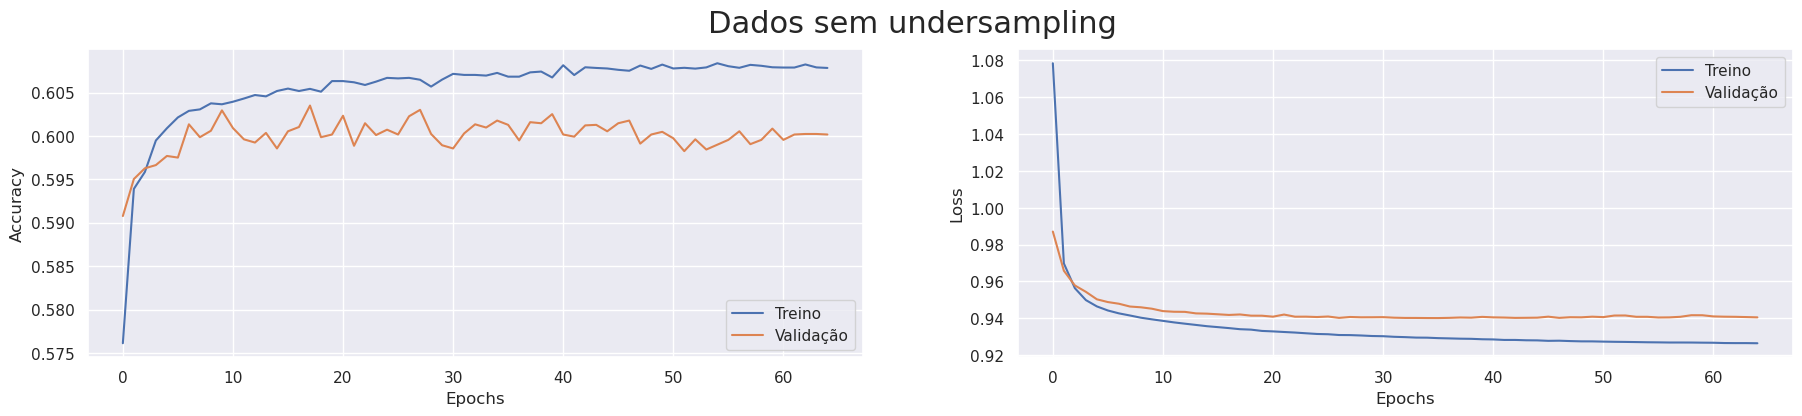

In [106]:
fig,axs=plt.subplots(1,2,figsize=(22,4))
fig.suptitle('Dados sem undersampling', fontsize=22) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
axs[0].plot(history_complete_data.history['accuracy'],label='Treino')
axs[0].plot(history_complete_data.history['val_accuracy'],label='Validação')
axs[0].set(ylabel='Accuracy')
axs[0].set(xlabel='Epochs')
axs[0].legend()

axs[1].plot(history_complete_data.history['loss'],label='Treino')
axs[1].plot(history_complete_data.history['val_loss'],label='Validação')
axs[1].set(ylabel='Loss')
axs[1].set(xlabel='Epochs')
axs[1].legend()




In [107]:
#Treinar modelo com undersampling
early_stopping_callback=EarlyStopping(monitor='accuracy',patience=10,restore_best_weights=True) #Early stopping
batch_size=32
epochs=200

neural_net_undersampling=criar_MLP([10],activation='sigmoid',input_shape=x_treino_pp.shape[1:],n_outputs=n_outputs,lr=lr,dropout_rate=0)


history_undersampling=neural_net_undersampling.fit(x=x_treino_pp_undersampled,callbacks=[early_stopping_callback],y=y_treino_pp_undersampled,batch_size=batch_size,
                       epochs=epochs,validation_data=[x_val_pp,y_val_pp])

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 91/240 [==========>...................] - ETA: 0s - loss: 1.6198 - accuracy: 0.2088

231/240 [===========================>..] - ETA: 0s - loss: 1.5979 - accuracy: 0.2516WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fde19eb6050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 2s 7ms/step - loss: 1.5967 - accuracy: 0.2546 - val_loss: 1.5978 - val_accuracy: 0.2167
Epoch 2/200
24

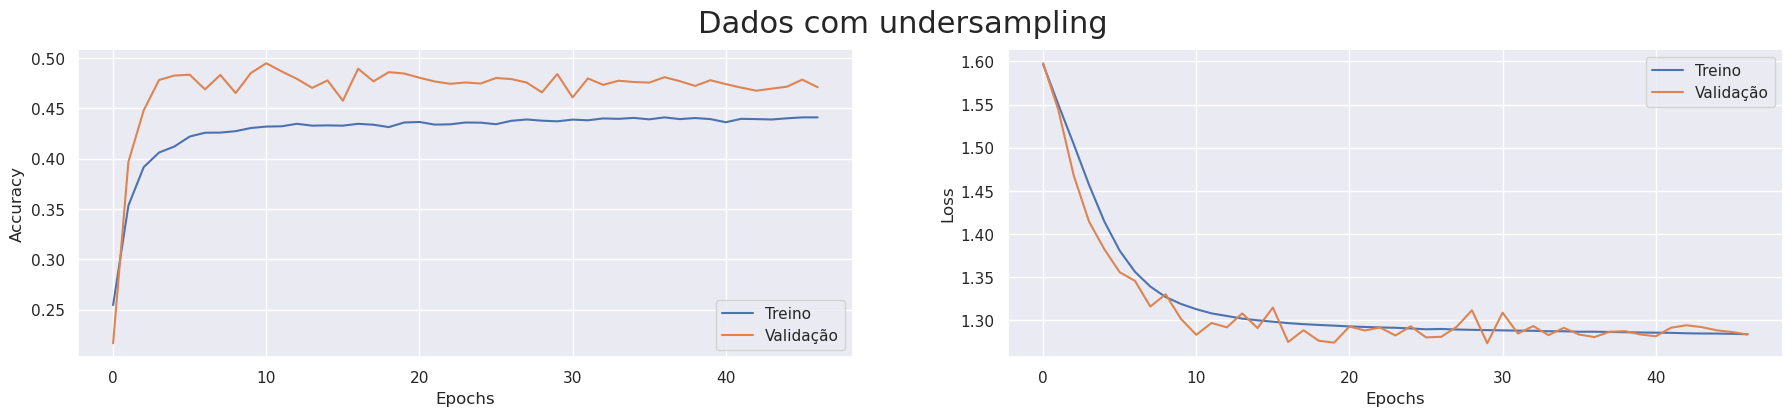

In [108]:
fig,axs=plt.subplots(1,2,figsize=(22,4))
fig.suptitle('Dados com undersampling', fontsize=22) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
axs[0].plot(history_undersampling.history['accuracy'],label='Treino')
axs[0].plot(history_undersampling.history['val_accuracy'],label='Validação')
axs[0].set(ylabel='Accuracy')
axs[0].set(xlabel='Epochs')
axs[0].legend()

axs[1].plot(history_undersampling.history['loss'],label='Treino')
axs[1].plot(history_undersampling.history['val_loss'],label='Validação')
axs[1].set(ylabel='Loss')
axs[1].set(xlabel='Epochs')
axs[1].legend()


### Analisar Resultados

In [109]:
classes=['Nota 1','Nota 2','Nota 3','Nota 4','Nota 5']

In [110]:
neural_net_complete_data.evaluate(x_val_pp,y_val_pp)

 63/506 [==>...........................] - ETA: 1s - loss: 0.9471 - accuracy: 0.5828

506/506 [==============================] - 3s 5ms/step - loss: 0.9408 - accuracy: 0.5990


[0.9408337473869324, 0.5989866256713867]

In [111]:
neural_net_complete_data.evaluate(x_teste_pp,y_teste_pp)

 68/633 [==>...........................] - ETA: 1s - loss: 0.9363 - accuracy: 0.5878

633/633 [==============================] - 4s 6ms/step - loss: 0.9358 - accuracy: 0.6016


[0.9357507228851318, 0.6015621423721313]

In [114]:
neural_net_undersampling.evaluate(x_val_pp,y_val_pp)

146/506 [=======>......................] - ETA: 2s - loss: 1.2761 - accuracy: 0.4839

506/506 [==============================] - 3s 6ms/step - loss: 1.2806 - accuracy: 0.4808


[1.280564785003662, 0.48078349232673645]

In [118]:
y_pred_complete=neural_net_complete_data.predict(x_teste_pp)
y_pred_undersampling=neural_net_undersampling.predict(x_teste_pp)

 21/633 [..............................] - ETA: 1s 

633/633 [==============================] - 5s 8ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
633/633 [==============================] - 10s 15ms/step


In [119]:
cm_complete=confusion_matrix(np.argmax(y_teste_pp,axis=1),np.argmax(y_pred_complete,axis=1))
cm_complete

array([[  142,     8,    77,    28,   225],
       [   91,    11,   154,    79,   260],
       [   63,     8,   519,   520,  1070],
       [   31,     0,   362,   895,  4078],
       [   41,     5,   204,   756, 10602]])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 1200x800 with 0 Axes>

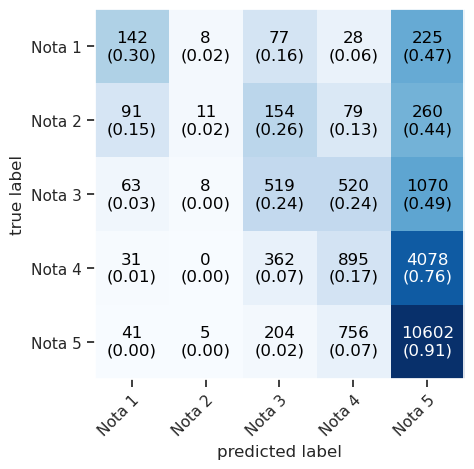

In [120]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(conf_mat=cm_complete,
                                colorbar=False,
                                show_absolute=True,
                                 show_normed=True,
                              class_names=classes)

In [121]:
cm_undersampling=confusion_matrix(np.argmax(y_teste_pp,axis=1),np.argmax(y_pred_undersampling,axis=1))
cm_undersampling

array([[ 300,   65,   44,   18,   53],
       [ 246,  122,  124,   26,   77],
       [ 298,  323,  876,  313,  370],
       [ 362,  341, 1255, 1189, 2219],
       [ 768,  488, 1184, 1845, 7323]])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 1200x800 with 0 Axes>

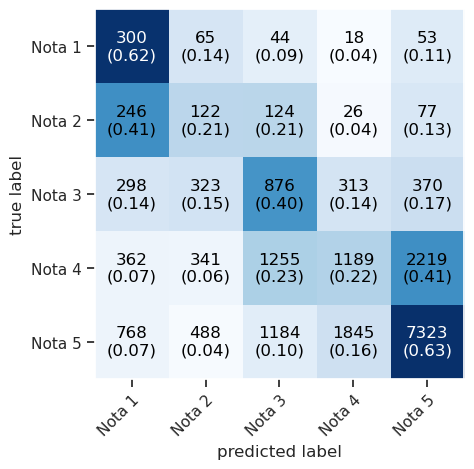

In [122]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(conf_mat=cm_undersampling,
                                colorbar=False,
                                show_absolute=True,
                                 show_normed=True,
                              class_names=classes)

### Gridsearch

Ajustar alguns parâmetros em busca da melhor acurácia possível.
Para combinar o gridsearch do sklearn com modelo criado no keras será usada a biblioteca scikeras


#### Comparar algumas funções de ativação e número de neurônios nas duas camadas totalmente conectadas

In [54]:
def get_model(hidden_layer_dim,activation,dropout_rate):

    neural_net=Sequential()
    neural_net.add(Input(shape=x_treino_pp.shape[1:]))
    neural_net.add(Dense(hidden_layer_dim,activation=activation))
    neural_net.add(Dropout(dropout_rate))
    neural_net.add(Dense(hidden_layer_dim,activation=activation))
    neural_net.add(Dropout(dropout_rate))
    neural_net.add(Dense(y_treino_pp.shape[1]))
    neural_net.add(Activation("softmax"))
    opt=optimizers.Adam(learning_rate=lr)
    neural_net.compile(loss='categorical_crossentropy',optimizer=opt)
    return neural_net

neural_model = KerasClassifier(
    model=get_model,
    hidden_layer_dim=10,
    activation='relu',
    optimizer="adam",
    epochs=100,
    dropout_rate=0.2)

#neural_model.fit(x_treino_pp,y_treino_pp)

params = {
    "hidden_layer_dim": [10, 20, 30],
    'activation':['relu','sigmoid','tanh'],
    'dropout_rate':np.arange(0,0.6,0.1)}

#gs = GridSearchCV(neural_model, params, refit=False, cv=3)
#gs.fit(x_treino_pp,y_treino_pp)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
200/200 [==============================] - 9s 23ms/step - loss: 1.1687
Epoch 2/100
200/200 [==============================] - 5s 25ms/step - loss: 1.0466
Epoch 3/100
200/200 [==============================] - 5s 27ms/step - loss: 1.0202
Epoch 4/100
200/200 [==============================] - 5s 24ms/step - loss: 0.9902
Epoch 5/100
200/200 [=========================

In [57]:
#print(gs.best_score_, gs.best_params_)
'''
OS melhores parâmetros encontrados no gridsearch foram os seguintes:

0.13 {'activation': 'sigmoid', 'hidden_layer_dim': 20}
'''

0.13 {'activation': 'sigmoid', 'hidden_layer_dim': 20}


# Modelos para Processamento de Linguagem Natural


## Pré-processamento dos dados

In [54]:
for nome_destino in nomes_destinos:
    dados[nome_destino]['destino']=nome_destino
df_dados=pd.concat([dados[destino] for destino in nomes_destinos],axis=0)
df_dados.reset_index(inplace=True,drop=True)

In [55]:
#Inputs do modelos são os comentários e outputs são as notas
df_x=df_dados[['comentario']].copy()
df_y=df_dados[['nota']].copy()
del df_dados

In [56]:
#separacao treino, validação e teste
x_treino,x_val,y_treino,y_val    =train_test_split(df_x,df_y,test_size=0.2,stratify=df_y,random_state=42)
x_treino,x_teste,y_treino,y_teste=train_test_split(x_treino,y_treino,test_size=0.2,stratify=y_treino,random_state=42)
del df_x,df_y


### Pré-processamento com NLTK

In [10]:
tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
x_treino['tokens']     =x_treino['comentario'].apply(lambda x:x.lower())          #letras minúsculas
x_treino['tokens']     =x_treino['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação



In [11]:
x_treino

,comentario,tokens
4493,"Apesar do calor, muito bonito ver as cataratas...","[apesar, do, calor, muito, bonito, ver, as, ca..."
91553,O parque é bonito e bem grande. Mas deixa a de...,"[parque, bonito, bem, grande, mas, deixa, dese..."
93062,Foi muito divertido possui muitas atrações pen...,"[foi, muito, divertido, possui, muitas, atraçõ..."
55934,"Copacabana é Copacabana!Lugar lindo, mas que n...","[copacabana, copacabana, lugar, lindo, mas, qu..."
57741,"Lindo mar azul, calçada bem larga primo para u...","[lindo, mar, azul, calçada, bem, larga, primo,..."
...,...,...
96594,Super organizado. Aplicativo excelente mostra ...,"[super, organizado, aplicativo, excelente, mos..."
13970,"O museu está muito bem conservado e mantido, i...","[museu, está, muito, bem, conservado, mantido,..."
79182,"Gostei muito do local, comi o melhor acarajé d...","[gostei, muito, do, local, comi, melhor, acara..."
85188,Pude apreciar a maior exposição de Caravaggio ...,"[pude, apreciar, maior, exposição, de, caravag..."


In [12]:
#stop words são palavras que aparecem comumente em frases e carregam pouca informação. Stopwords contém uma lista desse tipo de palavra que serão removidas dos comentários,
#uma vez que ela não teriam relevância para caracterizar um comentário.

#As palavras na lista de stopwords aparecem com acento. Sendo assim a remoção das stopwords deve acontecer antes da retirada da acentuação
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [13]:
x_treino['num_words']=x_treino['tokens'].apply(lambda x:len(x))

In [14]:
x_treino.describe()

,num_words
count,64732.000000
mean,39.712383
std,37.094634
min,0.000000
25%,20.000000
50%,29.000000
75%,45.000000
max,1351.000000


<AxesSubplot:title={'center':'Número de palavras nos comentários'}, xlabel='num_words'>

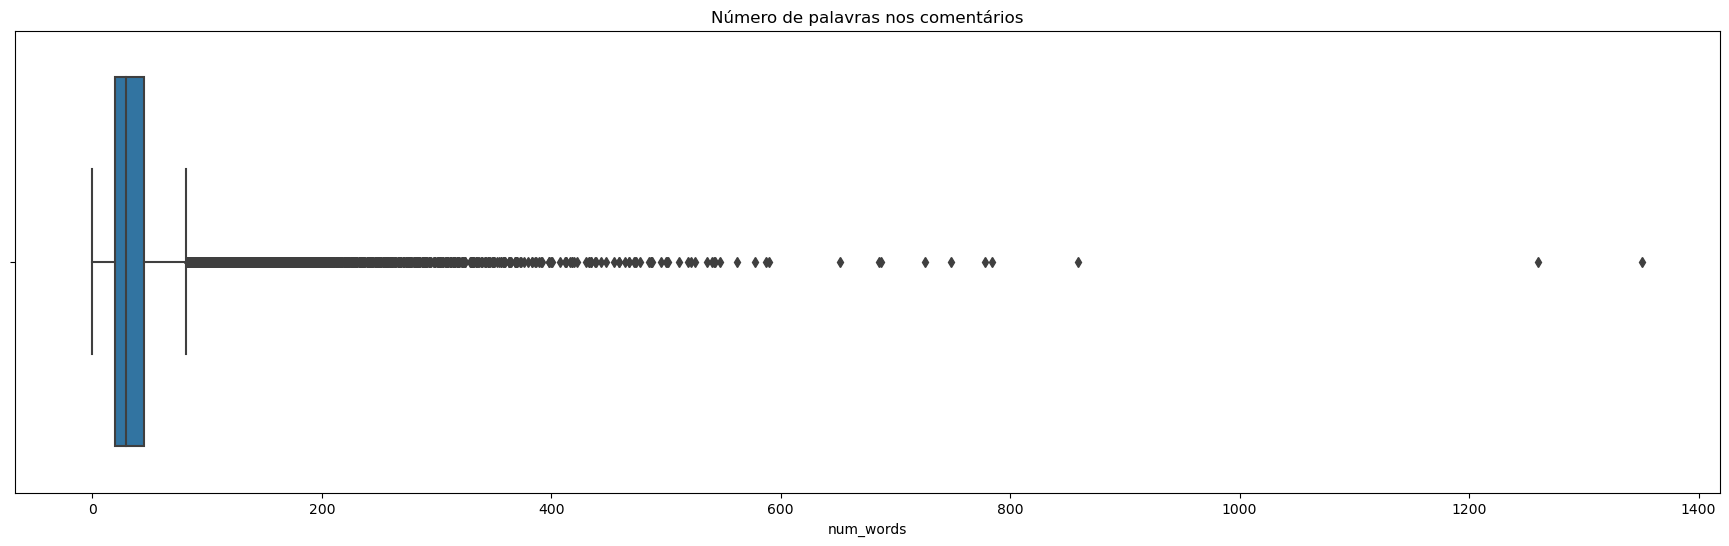

In [15]:
#Número de palavras nos comentários:
#A grande maioria dos comentários tem pequeno número de palavras, 75% deles tem menos de 45 palavras.

plt.figure(figsize=[22,6])
plt.title("Número de palavras nos comentários")
sns.boxplot(data=x_treino,x='num_words',orient='h')

Text(0.5, 9.444444444444438, 'Número de Palavras')

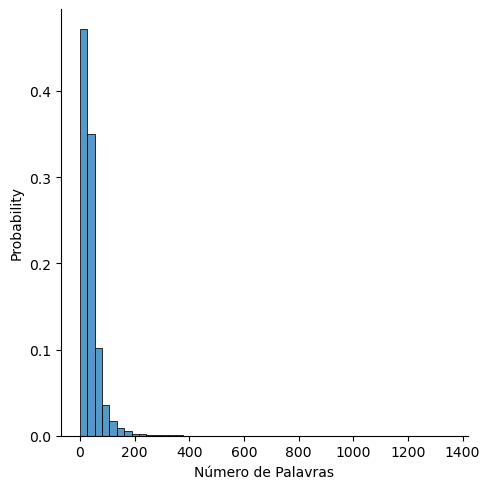

In [16]:
#A grande maioria dos comentários tem pequeno número de palavras, poucos tem mais de 200.

sns.displot(data=x_treino,x='num_words',bins=50,stat='probability' )
plt.xlabel('Número de Palavras')


In [17]:
#Remover comentários com 0 tokens
x_treino.drop(x_treino[x_treino['num_words']==0].index,inplace=True)

In [18]:
#Calcular proporção de stopwords nos comentários
#Razão entre o número de stopwords e o número total de palavras em cada comentário
x_treino['freq_stopwords']=x_treino['tokens'].apply(lambda x:len([word for word in x if word in stopwords])/len(x))

In [19]:
x_treino

,comentario,tokens,num_words,freq_stopwords
4493,"Apesar do calor, muito bonito ver as cataratas...","[apesar, do, calor, muito, bonito, ver, as, ca...",20,0.400000
91553,O parque é bonito e bem grande. Mas deixa a de...,"[parque, bonito, bem, grande, mas, deixa, dese...",37,0.297297
93062,Foi muito divertido possui muitas atrações pen...,"[foi, muito, divertido, possui, muitas, atraçõ...",26,0.384615
55934,"Copacabana é Copacabana!Lugar lindo, mas que n...","[copacabana, copacabana, lugar, lindo, mas, qu...",33,0.393939
57741,"Lindo mar azul, calçada bem larga primo para u...","[lindo, mar, azul, calçada, bem, larga, primo,...",17,0.294118
...,...,...,...,...
96594,Super organizado. Aplicativo excelente mostra ...,"[super, organizado, aplicativo, excelente, mos...",52,0.288462
13970,"O museu está muito bem conservado e mantido, i...","[museu, está, muito, bem, conservado, mantido,...",22,0.363636
79182,"Gostei muito do local, comi o melhor acarajé d...","[gostei, muito, do, local, comi, melhor, acara...",24,0.375000
85188,Pude apreciar a maior exposição de Caravaggio ...,"[pude, apreciar, maior, exposição, de, caravag...",23,0.260870


Text(0.5, 9.444444444444438, 'Proporção de stopwords nos comentários')

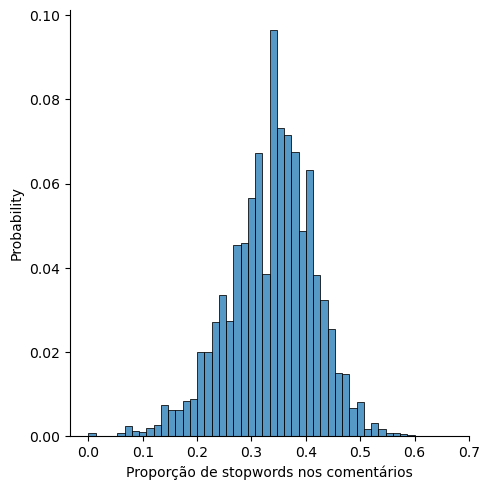

In [20]:
#A maior parte dos comentários tem entre 30 a 40% das palavras compostas de stopwords
sns.displot(data=x_treino,x='freq_stopwords',bins=50,stat='probability' )
plt.xlabel('Proporção de stopwords nos comentários')

In [21]:
#Remoção de stopwords
x_treino['tokens_no_stowords']=x_treino['tokens'].apply(lambda x:[word for word in x if word not in stopwords])

In [22]:
#Exemplo de tokens de um comentário com stopwords
x_treino.iloc[0,1]

['apesar',
 'do',
 'calor',
 'muito',
 'bonito',
 'ver',
 'as',
 'cataratas',
 'na',
 'parte',
 'superior',
 'também',
 'parte',
 'inferior',
 'sem',
 'contar',
 'com',
 'passeio',
 'de',
 'trem']

In [23]:
#Exemplo de tokens de um comentário sem stopwords
x_treino.iloc[0,4]

['apesar',
 'calor',
 'bonito',
 'ver',
 'cataratas',
 'parte',
 'superior',
 'parte',
 'inferior',
 'contar',
 'passeio',
 'trem']

#### Pré-processamento com NLTK


- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Remover acentos e substituir cedillha;
- Stemming.

In [57]:
def preprocess_nltk(dados,remover_acentos=False,coluna='comentario'):
    '''
    Funação recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Remoção pontuação
        -Remoção de stop words;
        -Opcional: remover acentuação e substituir cedilha (caracteres presentes na lingua portuguesa)


    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários; 

    Output:
        -Dataframe com uma única coluna contendo os tokens pré-processados
    '''
    tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
    stopwords = nltk.corpus.stopwords.words('portuguese') #lista de stopwords na lingua portuguesa 
    dados=dados.copy()
    dados['tokens']     =dados[coluna].apply(lambda x:x.lower())          #letras minúsculas
    dados['tokens']     =dados['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
    dados['tokens']=dados['tokens'].apply(lambda x:[word for word in x if word not in stopwords]) #remover stop words
    if remover_acentos:
    #remover acentos e substituir cedilha
        dados['tokens']=dados['tokens'].apply(lambda x:[normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII') for word in x]) 
    dados.drop(coluna,axis=1,inplace=True)
    return dados

In [31]:
def stemmming_nltk(dados,coluna='token'):
    stemmer=nltk.RSLPStemmer()
    dados[coluna]=dados[coluna].apply(lambda x:[stemmer.stem[word] for word in x]) #stemming nos tokens
    return dados



### Pré-processamento com Spacy

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Remover acentos e substituir cedillha;
- Lemmantization.

In [61]:
def lemmantizar(dados,remover_acentos=False,coluna='comentario'):
    '''
    Funação recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Somente palavras nos comentários (remoção de pontuação, números, etc)
        -Remoção de stop words;
        -lemmantization;
        -Opcional: remover acentuação e substituir cedilha (caracteres presentes na lingua portuguesa)



    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários; 

    Output:
        -Dataframe com uma única coluna contendo em cada linha uma lista de tokens pré-processados
    '''
    dados=dados.copy()
    nlp=spacy.load("pt_core_news_lg")
    dados['tokens']=dados[coluna].apply(lambda x:x.lower()) #letras minúsuculas
    dados['tokens']=dados['tokens'].apply(lambda x: [token.lemma_ for token in nlp(x) if token.is_alpha and not token.is_stop]) #manutenção somente de palavras nos tokens
                                                                                                                                #e remoção de stopwords
    if remover_acentos:
        dados['tokens']=dados['tokens'].apply(lambda x:[normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII') for word in x]) #remover acentos e substituit cedilha
    dados.drop(coluna,axis=1,inplace=True)
    return dados

In [30]:
def padding_tokens(dados,num_words=25,coluna='tokens'):
    '''
    Função para padranizar o número de palavras nos comentários.
    Comentários com número de palavras maior que o especificado serão truncados, enquanto aos com número maior será aplicado padding

    inputs-
    dados     - dataframe com coluna contendo os tokens dos comentátios
    coluna    - coluna com tokens
    max_words - número máximo de palavras em cada comentário

    outputs-
    Dataframe com todos os comentários com mesmo número de tokens;
    Cada comentário no formato [1,num_words]
    '''
    dados[coluna]=dados[coluna].apply(lambda x: [x[:num_words]if len(x)>num_words else x+(num_words-len(x))*['pad']])
    dados[coluna]=dados[coluna].apply(lambda x:np.array(x).reshape([1,-1]))
    dados=np.array(dados[coluna])
    dados=np.concatenate(dados,axis=0)
    return dados

### Pipelines de pré-processamento

In [22]:

#Pipeline de pre_processamento
#A pipeline de treino aplicará as funções de pré-processamento e em seguida
#O undersampling será aplicado somente sos dados de treinamento. O modelo será avaliado com dados com a propoção original de comnetários com cada nota.
pipeline_treino=make_pipeline(FunctionTransformer(lemmantizar),
                            FunctionTransformer(padding_tokens),
                            RandomUnderSampler(random_state=42))

#A pipeline de teste aplicará somente o pré_processamento
pipeline_val_teste=make_pipeline(FunctionTransformer(lemmantizar),
                                FunctionTransformer(padding_tokens))

In [30]:
x_treino,y_treino=pipeline_treino.fit_resample(x_treino,y_treino_encoded)
x_treino.to_pickle('x_treino_lemmantization_acentos.pkl')
np.save('y_treino.npy',y_treino)

AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'

In [10]:
#x_treino =pd.read_pickle("x_treino_lemmantization_acentos.pkl")
#y_treino =pd.read_pickle("y_treino.pkl")

In [23]:
x_teste=pipeline_val_teste.fit_transform(x_teste)


In [24]:
x_teste

,tokens
16615,"[[passeio, interessante, história, nação, prog..."
72286,"[[passeio, histórico, rua, pelourinho, visitar..."
57228,"[[trabalhei, voluntário, olimpíada, rio, marav..."
56469,"[[conhecido, praia, mundo, praia, copacabana, ..."
90662,"[[mundo, encantar, estruturar, atracão, inform..."
...,...
94535,"[[parque, muito, reforma, passagem, bloquear, ..."
25232,"[[enorme, cheio, artesanato, variedade, pesqui..."
56979,"[[amei, copa, lindo, limpo, quiosque, restaura..."
62052,"[[único, legal, elevador, lacerda, vista, cida..."


In [27]:
teste=np.concatenate(teste,axis=0)

In [39]:
x_val  =pipeline_val_teste.fit_transform(x_val)
x_teste=pipeline_val_teste.fit_transform(x_teste)
x_val.to_pickle('x_val_lemmantization_acentos.pkl')
y_val.to_pickle('y_val.pkl')
x_teste.to_pickle('x_teste_lemmantization_acentos.pkl')
y_teste.to_pickle('y_teste.pkl')

KeyError: 'tokens'

#### Criação do vocabulário

In [ ]:
def criar_vocabulario(dados_treino, max_words_vocab):
    vocab=Counter()
    for i in dados_treino:
        vocab.update(i)
    vocab=[word for word, count in vocab.most_common()[:max_words_vocab]]
    vocab=vocab+['oov']
    return vocab 
    

In [153]:
# Vocabulário contará com palavras acentuadas
vocab=Counter()
for num_row in range(len(x_treino)):
    vocab.update(x_treino.iloc[num_row,1])

In [154]:
#Total de palavras diferentes no vocabulário
len(vocab)

30955

In [155]:
#Palavras mais comuns no vocabulário
vocab.most_common()[:10]

[('parque', 21524),
 ('passeio', 11869),
 ('pena', 11699),
 ('dia', 10558),
 ('conhecer', 9971),
 ('lindo', 9110),
 ('ficar', 8793),
 ('visitar', 8780),
 ('cidade', 8573),
 ('bom', 8512)]

In [156]:
#Palavras menos comuns no vocabulário
#Diversas palavras apareceram um única vez, muitas delas são palavras com erros de grafia
vocab.most_common()[-1:-20:-1]

[('avolta', 1),
 ('principalemente', 1),
 ('ônix', 1),
 ('temais', 1),
 ('inacreditaval', 1),
 ('inedquecivel', 1),
 ('trancafiar', 1),
 ('cardial', 1),
 ('trafico', 1),
 ('chor', 1),
 ('revezei', 1),
 ('excallibur', 1),
 ('aquibancada', 1),
 ('reifeição', 1),
 ('furiozos', 1),
 ('aporveitar', 1),
 ('carroçal', 1),
 ('poderpublico', 1),
 ('irregularidade', 1)]

In [157]:
vocab.most_common()[10000:10010]

[('passeo', 4),
 ('extraordinariamente', 4),
 ('mesas', 4),
 ('dejeto', 4),
 ('invenção', 4),
 ('hematoma', 4),
 ('doque', 4),
 ('traseiro', 4),
 ('merce', 4),
 ('humanos', 4)]

In [158]:
num_words_vocab=10000 #Número de palavras que serão mantidas no vocabulário 
vocab_reduzido=[word for word, count in vocab.most_common()[:num_words_vocab]]
vocab_reduzido

['parque',
 'passeio',
 'pena',
 'dia',
 'conhecer',
 'lindo',
 'ficar',
 'visitar',
 'cidade',
 'bom',
 'valer',
 'jardim',
 'muito',
 'cuidado',
 'visita',
 'pra',
 'bonito',
 'fila',
 'museu',
 'atração',
 'brinquedo',
 'foto',
 'vale',
 'haver',
 'pessoa',
 'maravilhoso',
 'praia',
 'preço',
 'achar',
 'elevador',
 'curitiba',
 'deixar',
 'história',
 'criança',
 'pelourinho',
 'mercado',
 'vista',
 'passar',
 'ser',
 'limpo',
 'família',
 'ter',
 'ótimo',
 'trilha',
 'excelente',
 'tirar',
 'levar',
 'show',
 'lir',
 'andar',
 'comprar',
 'salvador',
 'entrada',
 'opção',
 'restaurante',
 'organizar',
 'turista',
 'natureza',
 'hora',
 'gostar',
 'brasil',
 'alto',
 'interessante',
 'super',
 'estar',
 'chegar',
 'botânico',
 'água',
 'turístico',
 'legal',
 'poder',
 'comida',
 'estrutura',
 'cheio',
 'belo',
 'ver',
 'estacionamento',
 'incrível',
 'pequeno',
 'rio',
 'ir',
 'encontrar',
 'ano',
 'voltar',
 'recomendar',
 'caminhada',
 'agradável',
 'estufa',
 'beleza',
 'acesso

In [159]:
vocab_reduzido=['<pad>']+vocab_reduzido+['oov']
vocab_reduzido

['<pad>',
 'parque',
 'passeio',
 'pena',
 'dia',
 'conhecer',
 'lindo',
 'ficar',
 'visitar',
 'cidade',
 'bom',
 'valer',
 'jardim',
 'muito',
 'cuidado',
 'visita',
 'pra',
 'bonito',
 'fila',
 'museu',
 'atração',
 'brinquedo',
 'foto',
 'vale',
 'haver',
 'pessoa',
 'maravilhoso',
 'praia',
 'preço',
 'achar',
 'elevador',
 'curitiba',
 'deixar',
 'história',
 'criança',
 'pelourinho',
 'mercado',
 'vista',
 'passar',
 'ser',
 'limpo',
 'família',
 'ter',
 'ótimo',
 'trilha',
 'excelente',
 'tirar',
 'levar',
 'show',
 'lir',
 'andar',
 'comprar',
 'salvador',
 'entrada',
 'opção',
 'restaurante',
 'organizar',
 'turista',
 'natureza',
 'hora',
 'gostar',
 'brasil',
 'alto',
 'interessante',
 'super',
 'estar',
 'chegar',
 'botânico',
 'água',
 'turístico',
 'legal',
 'poder',
 'comida',
 'estrutura',
 'cheio',
 'belo',
 'ver',
 'estacionamento',
 'incrível',
 'pequeno',
 'rio',
 'ir',
 'encontrar',
 'ano',
 'voltar',
 'recomendar',
 'caminhada',
 'agradável',
 'estufa',
 'beleza'

In [160]:
#Substituir cada token pelo seu index novocabulario

#palavras desconhecidas serão substituídas pelo index vocab_size+2
index_desconhecido=num_words_vocab+2

x_treino['index_words']=x_treino['tokens'].apply(lambda x:[vocab_reduzido.index(word) if word in vocab_reduzido else vocab_reduzido.index('oov') for word in x])

In [161]:
x_treino.describe()

,num_words
count,64732.000000
mean,20.915421
std,18.892706
min,2.000000
25%,11.000000
50%,15.000000
75%,24.000000
max,642.000000


In [162]:
#Padronizar comentários para mesmo número de palavras
#Comentários com número de palavras maior que o estipulados serão truncados
#Será adicionado padding aos comentários com número de palavras inferior ao mínimo

max_words=25 #número máximo de palavras em cada comentário

x_treino['index_words']=x_treino['index_words'].apply(lambda x:x[:max_words] if len(x)>=max_words else x+(max_words-len(x))*[0])


In [163]:
#Verificar se o número de tokens agora em todos os comentários é igual
x_treino['num_words']=x_treino['index_words'].apply(lambda x:len(x))

In [164]:
x_treino.describe()

,num_words
count,64732.0
mean,25.0
std,0.0
min,25.0
25%,25.0
50%,25.0
75%,25.0
max,25.0


#### Dados para o modelo

In [165]:
x_treino.head()

,comentario,tokens,num_words,index_words
4493,"Apesar do calor, muito bonito ver as cataratas...","[apesar, calor, bonito, catarata, alto, inferi...",25,"[130, 330, 17, 113, 62, 1646, 153, 2, 829, 0, ..."
91553,O parque é bonito e bem grande. Mas deixa a de...,"[parque, bonito, deixar, desejar, alimentação,...",25,"[1, 17, 32, 276, 161, 390, 236, 269, 11, 28, 1..."
93062,Foi muito divertido possui muitas atrações pen...,"[divertido, possuir, muito, atração, pena, fil...",25,"[348, 118, 13, 20, 3, 18, 39, 97, 1203, 97, 53..."
55934,"Copacabana é Copacabana!Lugar lindo, mas que n...","[copacabana, lindo, aconselhável, jóia, celula...",25,"[111, 6, 2506, 996, 462, 1111, 506, 16, 252, 4..."
57741,"Lindo mar azul, calçada bem larga primo para u...","[lindo, mar, azul, calçada, largo, primo, pass...",25,"[6, 148, 1178, 820, 939, 2946, 2, 14, 4596, 77..."


In [166]:
x_treino=x_treino[['index_words']].copy()

In [167]:
x_treino.head()

,index_words
4493,"[130, 330, 17, 113, 62, 1646, 153, 2, 829, 0, ..."
91553,"[1, 17, 32, 276, 161, 390, 236, 269, 11, 28, 1..."
93062,"[348, 118, 13, 20, 3, 18, 39, 97, 1203, 97, 53..."
55934,"[111, 6, 2506, 996, 462, 1111, 506, 16, 252, 4..."
57741,"[6, 148, 1178, 820, 939, 2946, 2, 14, 4596, 77..."


In [168]:
y_treino.value_counts()

nota
5.0     37145
4.0     17170
3.0      6978
2.0      1903
1.0      1536
dtype: int64

In [188]:
#Random undersampler
resampler=RandomUnderSampler(random_state=42)
x_res,y_res=resampler.fit_resample(x_treino,y_treino)


# Corrigir shape (está gerando dados de uma dimensão)


In [191]:
x_res['index_words']=x_res['index_words'].apply(lambda x: np.asarray(x).astype('float32').reshape([1,-1]))
x_res

,index_words
0,"[[1509.0, 25.0, 380.0, 262.0, 2752.0, 849.0, 7..."
1,"[[5466.0, 564.0, 211.0, 1140.0, 1.0, 1447.0, 2..."
2,"[[168.0, 64.0, 3214.0, 30.0, 180.0, 37.0, 295...."
3,"[[2018.0, 128.0, 901.0, 223.0, 1787.0, 53.0, 1..."
4,"[[297.0, 217.0, 1269.0, 85.0, 130.0, 326.0, 14..."
...,...
7675,"[[4292.0, 7661.0, 36.0, 507.0, 10.0, 646.0, 12..."
7676,"[[184.0, 134.0, 184.0, 2.0, 27.0, 50.0, 676.0,..."
7677,"[[384.0, 1.0, 10001.0, 265.0, 17.0, 56.0, 109...."
7678,"[[6.0, 10.0, 105.0, 238.0, 267.0, 499.0, 12.0,..."


In [203]:
encoder=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_res=encoder.fit_transform(y_res)   

## LSTM

In [172]:
embedding_size=128
model=Sequential()
model.add(Embedding(len(vocab_reduzido),embedding_size,input_length=max_words))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(5,activation='softmax'))

2024-04-20 16:20:57.948009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [205]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
history=model.fit(x=teste_2,y=y_res,epochs=50)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 82s 286ms/step - loss: 1.3192 - accuracy: 0.3897
Epoch 2/50
240/240 [==============================] - 74s 309ms/step - loss: 1.0599 - accuracy: 0.5340
Epoch 3/50
240/240 [==============================] - 75s 313ms/step - loss: 0.9051 - accuracy: 0.6194
Epoch 4/50
240/240 [==============================] - 28s 117ms/step 

KeyboardInterrupt: 

In [60]:
x_treino

,comentario,tokens
4493,"Apesar do calor, muito bonito ver as cataratas...","[apesar, calor, bonito, catarata, alto, inferi..."
91553,O parque é bonito e bem grande. Mas deixa a de...,"[parque, bonito, deixar, desejar, alimentação,..."
93062,Foi muito divertido possui muitas atrações pen...,"[divertido, possuir, muito, atração, pena, fil..."
55934,"Copacabana é Copacabana!Lugar lindo, mas que n...","[Copacabana, lindo, aconselhável, jóia, celula..."
57741,"Lindo mar azul, calçada bem larga primo para u...","[lindo, mar, azul, calçada, largo, primo, pass..."
...,...,...
96594,Super organizado. Aplicativo excelente mostra ...,"[super, organizar, aplicativo, excelente, most..."
13970,"O museu está muito bem conservado e mantido, i...","[museu, conservar, manter, área, externo, agra..."
79182,"Gostei muito do local, comi o melhor acarajé d...","[Gostei, comi, bom, acarajé, cidade, museu, ba..."
85188,Pude apreciar a maior exposição de Caravaggio ...,"[Pude, apreciar, exposição, Caravaggio, realiz..."
